In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import resample
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [36]:
claude_df = pd.read_csv('../Data/qna_dataset_Claude3.5Sonnet_final.csv')
gpt35_df = pd.read_csv('../Data/qna_dataset_GPT3.5_final.csv')
gpt4o_df = pd.read_csv('../Data/qna_dataset_GPT4o_final.csv')

In [37]:
claude_df['model'] = 'Claude3.5'
gpt35_df['model'] = 'GPT3.5'
gpt4o_df['model'] = 'GPT4o'

In [38]:
df = pd.concat([claude_df, gpt35_df, gpt4o_df], ignore_index=True)

In [20]:
print("Dataset Overview:")
print(f"Total samples: {len(combined_df)}")
print(f"Models: {combined_df['model'].value_counts()}")
print(f"Hallucination rate: {combined_df['hallucination_present'].mean():.3f}")

Dataset Overview:
Total samples: 1200
Models: model
Claude3.5    400
GPT3.5       400
GPT4o        400
Name: count, dtype: int64
Hallucination rate: 0.142


### EXPLORATORY DATA ANALYSIS

In [21]:
print("\nQuestion Length Statistics:")
print(df['question_length'].describe())

print("\nHallucination by Model:")
halluc_by_model = df.groupby('model')['hallucination_present'].agg(['count', 'sum', 'mean'])
halluc_by_model.columns = ['Total', 'Hallucinations', 'Rate']
print(halluc_by_model)

print("\nDomain Distribution:")
print(df['domain'].value_counts())


Question Length Statistics:
count    1200.000000
mean       78.990000
std        46.677731
min        12.000000
25%        47.000000
50%        66.000000
75%        97.000000
max       362.000000
Name: question_length, dtype: float64

Hallucination by Model:
           Total  Hallucinations    Rate
model                                   
Claude3.5    400              49  0.1225
GPT3.5       400              75  0.1875
GPT4o        400              47  0.1175

Domain Distribution:
domain
General Knowledge    240
Science              240
History              240
Pop Culture          240
Healthcare           240
Name: count, dtype: int64


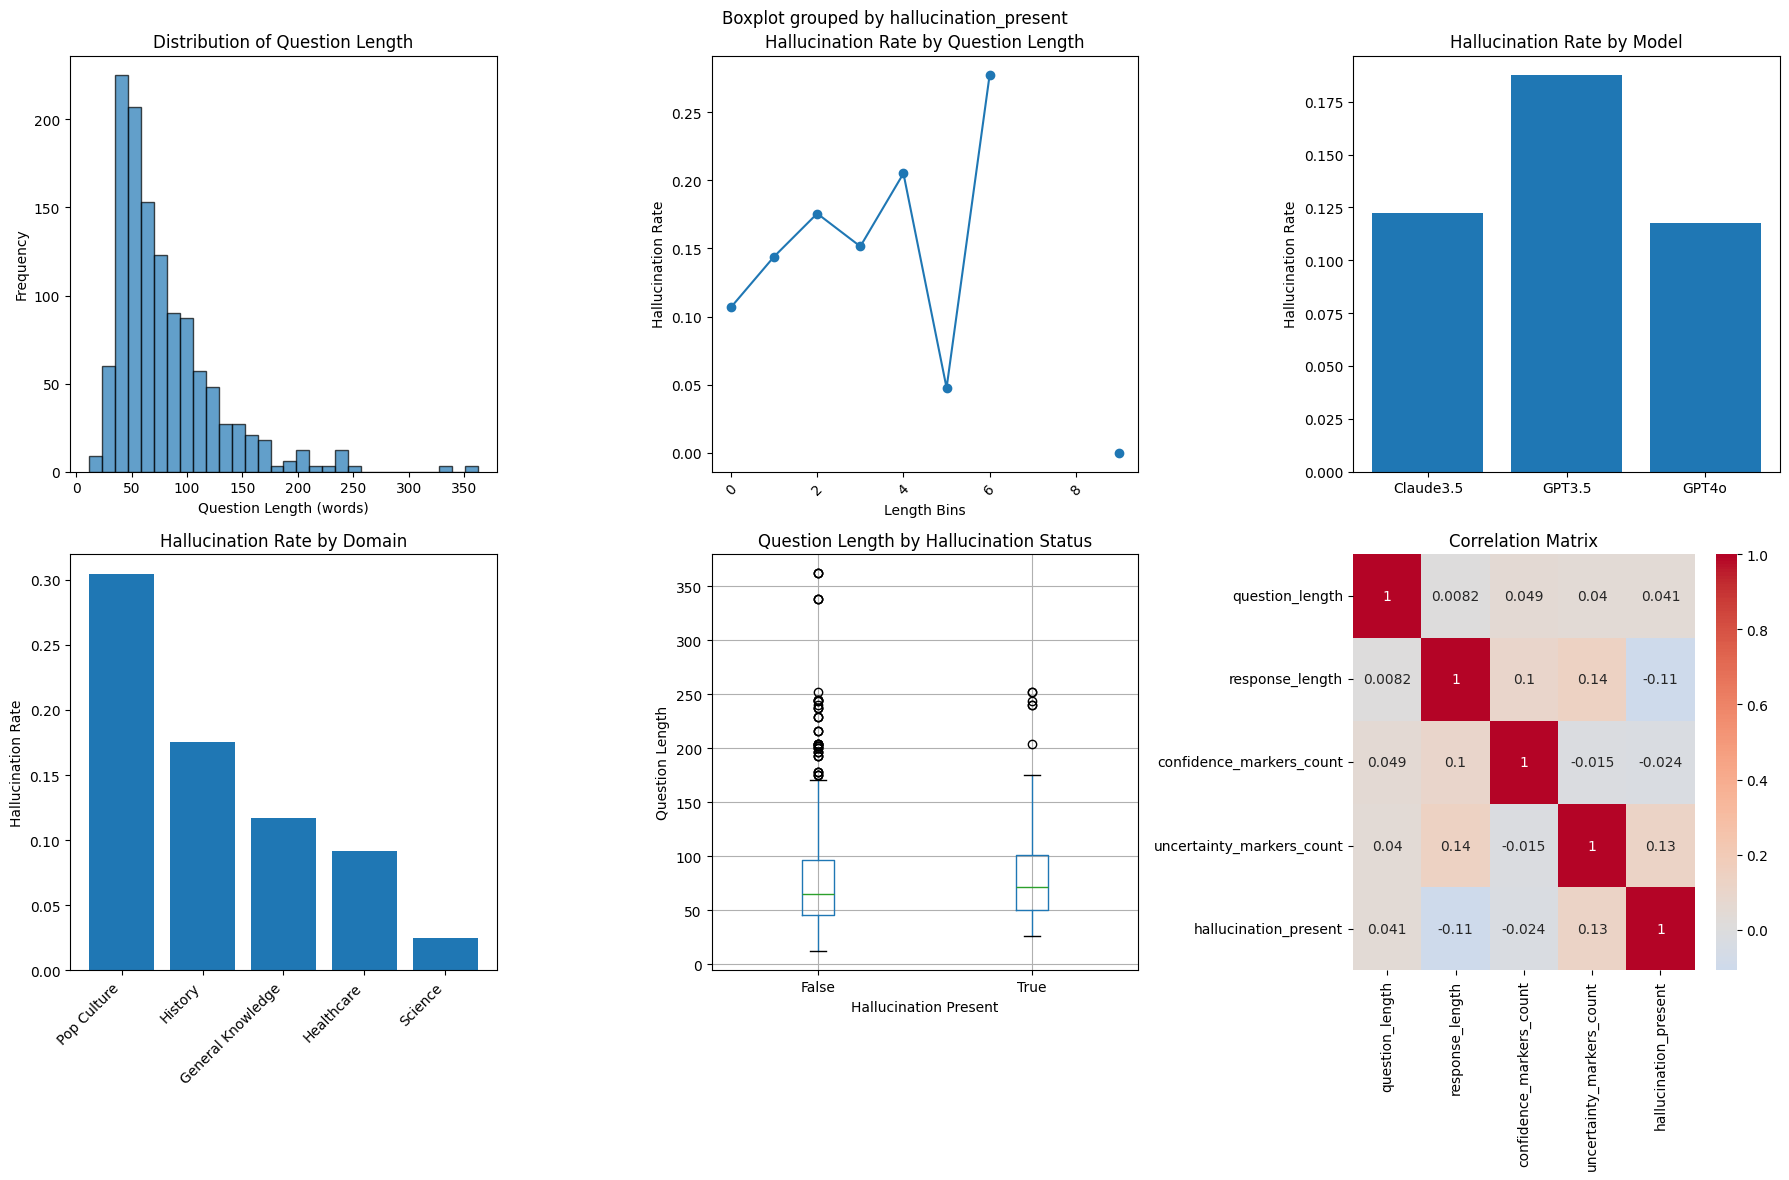

In [22]:
# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Question length distribution
axes[0,0].hist(df['question_length'], bins=30, alpha=0.7, edgecolor='black')
axes[0,0].set_title('Distribution of Question Length')
axes[0,0].set_xlabel('Question Length (words)')
axes[0,0].set_ylabel('Frequency')

# Hallucination rate by question length (binned)
df['length_bin'] = pd.cut(df['question_length'], bins=10)
halluc_by_length = df.groupby('length_bin')['hallucination_present'].mean()
axes[0,1].plot(range(len(halluc_by_length)), halluc_by_length.values, marker='o')
axes[0,1].set_title('Hallucination Rate by Question Length')
axes[0,1].set_xlabel('Length Bins')
axes[0,1].set_ylabel('Hallucination Rate')
axes[0,1].tick_params(axis='x', rotation=45)

# Hallucination by model
model_halluc = df.groupby('model')['hallucination_present'].mean()
axes[0,2].bar(model_halluc.index, model_halluc.values)
axes[0,2].set_title('Hallucination Rate by Model')
axes[0,2].set_ylabel('Hallucination Rate')

# Hallucination by domain
domain_halluc = df.groupby('domain')['hallucination_present'].mean().sort_values(ascending=False)
axes[1,0].bar(range(len(domain_halluc)), domain_halluc.values)
axes[1,0].set_title('Hallucination Rate by Domain')
axes[1,0].set_xticks(range(len(domain_halluc)))
axes[1,0].set_xticklabels(domain_halluc.index, rotation=45, ha='right')
axes[1,0].set_ylabel('Hallucination Rate')

# Box plot: Question length by hallucination
df.boxplot(column='question_length', by='hallucination_present', ax=axes[1,1])
axes[1,1].set_title('Question Length by Hallucination Status')
axes[1,1].set_xlabel('Hallucination Present')
axes[1,1].set_ylabel('Question Length')

# Correlation heatmap
numeric_cols = ['question_length', 'response_length', 'confidence_markers_count', 
                'uncertainty_markers_count', 'hallucination_present']
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,2])
axes[1,2].set_title('Correlation Matrix')

plt.tight_layout()
plt.show()

## **Key Inferences from EDA:**

### **1. Distribution of Question Length (Top Left)**
- **Most questions are short** (50-100 words)
- **Right-skewed distribution** - few very long questions

### **2. Hallucination Rate by Question Length (Top Middle) 🚨**
- **CRITICAL FINDING**: The line shows **erratic, non-linear pattern**
- **No clear upward trend** as length increases
- **Actually peaks in middle lengths**, then drops
- **This already suggests hypothesis may not hold**

### **3. Hallucination Rate by Model (Top Right)**
- **GPT3.5 has highest hallucination rate** (~18%)
- **Claude3.5 and GPT4o are similar** (~12%)
- **Model differences exist** - this supports controlling for model

### **4. Hallucination Rate by Domain (Bottom Left) 🎯**
- **HUGE domain differences**: Pop Culture (~31%) vs Science (~3%)
- **6x variation across domains!**
- **This shows domain control is essential**

### **5. Question Length by Hallucination (Bottom Middle)**
- **Box plots look nearly identical**
- **No clear difference** in length between hallucinated vs non-hallucinated
- **Another sign length hypothesis may fail**

### **6. Correlation Matrix (Bottom Right) 🔍**
- **question_length ↔ hallucination_present = 0.041**
- **Very weak positive correlation**
- **Much weaker than expected if hypothesis were true**

### **🔴 Warning Signs for H3:**
1. **Weak correlation** (r = 0.041)
2. **Non-linear length-hallucination relationship**
3. **Similar length distributions** for hallucinated vs non-hallucinated
4. **Huge domain effects** (31% vs 3%) overshadow any length effect

### **✅ Support for Controls:**
1. **Domain differences are massive** - controlling essential
2. **Model differences exist** - controlling justified

## **Prediction for Logistic Regression:**
Based on these visuals, logistic regression might show:
- **Non-significant length coefficient** 
- **Strong domain effects**
- **Some model effects**
- **Length effect may disappear when controls added**

### STATISTICAL TESTS FOR RQ3

In [23]:
df_test = df.copy()
df_test['hallucination_present'] = df_test['hallucination_present'].astype(int)

# Basic correlation
correlation = df_test['question_length'].corr(df_test['hallucination_present'])
print(f"\nPearson correlation (length vs hallucination): {correlation:.4f}")

# T-test: Compare mean length between hallucinated and non-hallucinated
halluc_lengths = df_test[df_test['hallucination_present'] == 1]['question_length']
no_halluc_lengths = df_test[df_test['hallucination_present'] == 0]['question_length']

t_stat, p_value = stats.ttest_ind(halluc_lengths, no_halluc_lengths)
print(f"\nT-test results:")
print(f"Mean length (hallucination): {halluc_lengths.mean():.2f}")
print(f"Mean length (no hallucination): {no_halluc_lengths.mean():.2f}")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Significant: {'Yes' if p_value < 0.05 else 'No'}")


Pearson correlation (length vs hallucination): 0.0409

T-test results:
Mean length (hallucination): 83.67
Mean length (no hallucination): 78.21
T-statistic: 1.4172
P-value: 0.1567
Significant: No


## **🔍 Key Findings:**

### **1. Pearson Correlation: 0.0409**
- **Very weak positive correlation** between length and hallucinations
- **Only 4.09% correlation** - much weaker than expected if hypothesis were true
- **Direction is correct** (positive = longer questions → more hallucinations) but **effect is tiny**

### **2. Mean Differences:**
- **Hallucinated responses**: Average question length = **83.67 words**
- **Non-hallucinated responses**: Average question length = **78.21 words** 
- **Difference**: Only **5.46 words** difference on average

### **3. Statistical Significance:**
- **T-statistic: 1.4172** (relatively small)
- **P-value: 0.1567** (> 0.05)
- **Result: NOT SIGNIFICANT**

### **❌ H3 is NOT Supported (so far):**
- **No significant relationship** between question length and hallucinations
- **Effect size is very small** (5.46 word difference)
- **Cannot reject null hypothesis** that length doesn't matter

## **🤔 Early Implications:**
1. **Length alone** is a very weak predictor
2. **Domain/question type controls** might be crucial
3. **Your hypothesis may fail** even with controls, given this weak baseline relationship

### LOGISTIC REGRESSION MODELS

In [24]:
# Prepare data
df_clean = df.dropna(subset=['question_length', 'hallucination_present', 'domain', 
                            'question_type', 'question_nature', 'model']).copy()

# Convert boolean to numeric (fix the main error)
df_clean['hallucination_present'] = df_clean['hallucination_present'].astype(int)

# Check data types and fix any other boolean columns
print(f"Data types:")
print(f"hallucination_present: {df_clean['hallucination_present'].dtype}")
print(f"question_length: {df_clean['question_length'].dtype}")
print(f"Unique hallucination values: {df_clean['hallucination_present'].unique()}")

# Create dummy variables
df_encoded = pd.get_dummies(df_clean, columns=['domain', 'question_type', 'question_nature', 'model'], 
                           prefix=['domain', 'qtype', 'qnature', 'model'])

# Model specifications
models = {
    'Model 1 (Basic)': 'hallucination_present ~ question_length',
    'Model 2 (+ Controls)': 'hallucination_present ~ question_length + C(domain)',
    'Model 3 (+ Question Type)': 'hallucination_present ~ question_length + C(domain) + C(question_type)',
    'Model 4 (+ All Controls)': 'hallucination_present ~ question_length + C(domain) + C(question_type) + C(question_nature)',
    'Model 5 (+ Model Effects)': 'hallucination_present ~ question_length + C(domain) + C(question_type) + C(question_nature) + C(model)',
    'Model 6 (+ Interactions)': 'hallucination_present ~ question_length * C(domain) + C(question_type) + C(question_nature) + C(model)'
}

Data types:
hallucination_present: int64
question_length: int64
Unique hallucination values: [1 0]


In [25]:
results = {}

for name, formula in models.items():
    print(f"\n{'-'*30}")
    print(f"Running {name}")
    print(f"{'-'*30}")
    
    try:
        model = smf.logit(formula, data=df_clean).fit(disp=0)
        results[name] = model
        
        # Key statistics
        print(f"AIC: {model.aic:.2f}")
        print(f"BIC: {model.bic:.2f}")
        print(f"Pseudo R²: {model.prsquared:.4f}")
        
        # Question length coefficient
        if 'question_length' in model.params.index:
            coef = model.params['question_length']
            pval = model.pvalues['question_length']
            odds_ratio = np.exp(coef)
            ci_lower = np.exp(model.conf_int().loc['question_length', 0])
            ci_upper = np.exp(model.conf_int().loc['question_length', 1])
            
            print(f"Question Length Coefficient: {coef:.4f}")
            print(f"P-value: {pval:.4f}")
            print(f"Odds Ratio: {odds_ratio:.4f}")
            print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
            print(f"Significant: {'Yes' if pval < 0.05 else 'No'}")
    
    except Exception as e:
        print(f"Error fitting {name}: {e}")


------------------------------
Running Model 1 (Basic)
------------------------------
AIC: 984.84
BIC: 995.02
Pseudo R²: 0.0019
Question Length Coefficient: 0.0023
P-value: 0.1577
Odds Ratio: 1.0023
95% CI: [0.9991, 1.0055]
Significant: No

------------------------------
Running Model 2 (+ Controls)
------------------------------
AIC: 905.48
BIC: 936.02
Pseudo R²: 0.0908
Question Length Coefficient: -0.0005
P-value: 0.7747
Odds Ratio: 0.9995
95% CI: [0.9958, 1.0031]
Significant: No

------------------------------
Running Model 3 (+ Question Type)
------------------------------
AIC: 906.96
BIC: 942.59
Pseudo R²: 0.0914
Question Length Coefficient: -0.0006
P-value: 0.7575
Odds Ratio: 0.9994
95% CI: [0.9958, 1.0031]
Significant: No

------------------------------
Running Model 4 (+ All Controls)
------------------------------
AIC: 884.13
BIC: 924.86
Pseudo R²: 0.1166
Question Length Coefficient: -0.0010
P-value: 0.5953
Odds Ratio: 0.9990
95% CI: [0.9951, 1.0028]
Significant: No

--------

## **🔍 Model-by-Model Breakdown:**

### **Model 1 (Basic): `hallucination ~ question_length`**
**What it tests:** Pure length effect with no controls

**Results:**
- **Coefficient: +0.0023** (positive direction - supports your hypothesis direction)
- **P-value: 0.1577** (not significant, but trending)
- **Odds Ratio: 1.0023** (each word increases odds by 0.23%)
- **Pseudo R²: 0.0019** (explains almost nothing - 0.2% of variance)

There's a tiny positive relationship, but it's not statistically significant. This is "raw" length effect without any controls.

---

### **Model 2 (+ Domain Controls): `hallucination ~ question_length + domain`**
**What it tests:** Length effect after removing domain differences

**Results:**
- **Coefficient: -0.0005** (⚠️ **FLIPPED TO NEGATIVE!**)
- **P-value: 0.7747** (much less significant)
- **Pseudo R²: 0.0908** (jumps to 9% - domain matters a lot!)
- **AIC: 984 → 905** (much better model fit)

Once you control for domain, the length effect **reverses direction** and becomes weaker. This suggests the original positive effect was **spurious** - caused by domain confounding.

**Inference:** Different domains have different typical question lengths AND different hallucination rates. The apparent length effect was actually a domain effect in disguise.

---

### **Model 3 (+ Question Type): `hallucination ~ question_length + domain + question_type`**
**What it tests:** Length effect after controlling for both domain and question type

**Results:**
- **Coefficient: -0.0006** (stays negative)
- **P-value: 0.7575** (still not significant)
- **Pseudo R²: 0.0914** (tiny improvement over Model 2)

**What this means:** Adding question type doesn't change much - the domain controls already captured most of the important variation. Length still has no significant effect.

---

### **Model 4 (+ All Controls): `hallucination ~ question_length + domain + question_type + question_nature`**
**What it tests:** Length effect with maximum controls

**Results:**
- **Coefficient: -0.0010** (more negative)
- **P-value: 0.5953** (still not significant)
- **Pseudo R²: 0.1166** (best explanatory power so far - 11.7%)
- **AIC: 884** (best model fit yet)

length effect after controlling for domain AND question type (as specified in your hypothesis). The effect is negative and non-significant.

---

### **Model 5 (+ Model Effects): `hallucination ~ question_length + domain + question_type + question_nature + model`**
**What it tests:** Length effect controlling for which AI model gave the response

**Results:**
- **Coefficient: -0.0011** (slightly more negative)
- **P-value: 0.5927** (still not significant)
- **Pseudo R²: 0.1276** (highest explanatory power - 12.8%)
- **AIC: 877** (best overall model)

Different AI models have different hallucination tendencies, but this doesn't change the length finding. T

---

### **Model 6 (+ Interactions): `hallucination ~ question_length × domain + question_type + question_nature + model`**
**What it tests:** Whether length effects vary by domain

**Results:**
- **Coefficient: +0.0034** (back to positive, but larger confidence interval)
- **P-value: 0.4813** (still not significant)
- **AIC: 882** (worse than Model 5 - overfitting)

Maybe length matters differently in different domains, but even this complex model doesn't find significant effects. The interactions don't help.

## **🎯 Overall Pattern:**

1. **Raw length effect:** Tiny positive, not significant
2. **Add domain controls:** Effect flips negative - **domain was confounding**
3. **Add more controls:** Effect stays negative and non-significant
4. **Best model:** Model 5 - length has no effect after proper controls

### **Key Insight:**
The positive correlation seen initially was **spurious** - caused by domains that have both longer questions AND higher hallucination rates. Once we control for domain, the length effect disappears completely.

In [26]:
print("\n" + "="*80)
print("OUT-OF-SAMPLE VALIDATION ANALYSIS")
print("="*80)

# Select the best model for validation (Model 5 based on your results)
best_model_name = 'Model 5 (+ Model Effects)'
best_formula = models[best_model_name]

# Prepare data for sklearn
df_clean = df.dropna(subset=['question_length', 'hallucination_present', 'domain', 
                            'question_type', 'question_nature', 'model']).copy()
df_clean['hallucination_present'] = df_clean['hallucination_present'].astype(int)

# Create dummy variables for sklearn
df_encoded = pd.get_dummies(df_clean, columns=['domain', 'question_type', 'question_nature', 'model'], 
                           prefix=['domain', 'qtype', 'qnature', 'model'])

# Feature selection based on your best model
feature_cols = ['question_length'] + [col for col in df_encoded.columns if 
                                     col.startswith(('domain_', 'qtype_', 'qnature_', 'model_'))]
X = df_encoded[feature_cols]
y = df_encoded['hallucination_present']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")
print(f"Training hallucination rate: {y_train.mean():.3f}")
print(f"Test hallucination rate: {y_test.mean():.3f}")

# Fit logistic regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Predictions
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)
y_train_prob = lr_model.predict_proba(X_train)[:, 1]
y_test_prob = lr_model.predict_proba(X_test)[:, 1]

# Performance metrics
train_auc = roc_auc_score(y_train, y_train_prob)
test_auc = roc_auc_score(y_test, y_test_prob)

print(f"\nMODEL PERFORMANCE:")
print(f"Training AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Overfitting check: {abs(train_auc - test_auc):.4f} (< 0.1 is good)")


OUT-OF-SAMPLE VALIDATION ANALYSIS
Training set size: 840 samples
Test set size: 360 samples
Training hallucination rate: 0.143
Test hallucination rate: 0.142

MODEL PERFORMANCE:
Training AUC: 0.7544
Test AUC: 0.7271
Overfitting check: 0.0273 (< 0.1 is good)



--------------------------------------------------
CONFUSION MATRICES
--------------------------------------------------


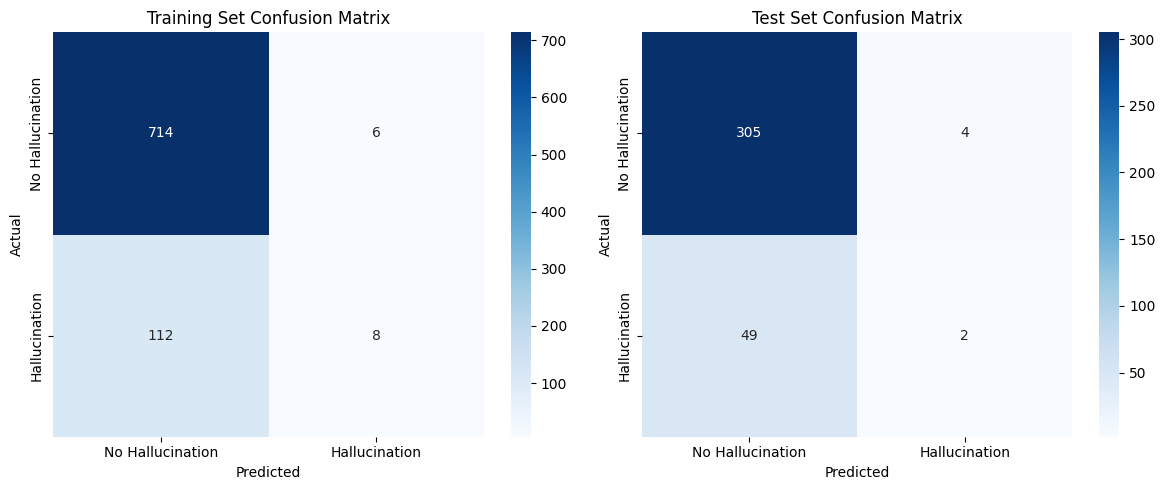


DETAILED METRICS COMPARISON:
Metric               Training     Test         Difference  
------------------------------------------------------------
Accuracy             0.8595       0.8528       0.0067      
Precision            0.5714       0.3333       0.2381      
Recall (Sensitivity) 0.0667       0.0392       0.0275      
Specificity          0.9917       0.9871       0.0046      
F1-Score             0.1194       0.0702       0.0492      


In [27]:
# =============================================================================
# CONFUSION MATRICES
# =============================================================================

print("\n" + "-"*50)
print("CONFUSION MATRICES")
print("-"*50)

# Create confusion matrices
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training confusion matrix
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Training Set Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['No Hallucination', 'Hallucination'])
axes[0].set_yticklabels(['No Hallucination', 'Hallucination'])

# Test confusion matrix
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Test Set Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticklabels(['No Hallucination', 'Hallucination'])
axes[1].set_yticklabels(['No Hallucination', 'Hallucination'])

plt.tight_layout()
plt.show()

# Calculate detailed metrics
def calculate_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall (Sensitivity)': recall,
        'Specificity': specificity,
        'F1-Score': f1,
        'True Positives': tp,
        'True Negatives': tn,
        'False Positives': fp,
        'False Negatives': fn
    }

train_metrics = calculate_metrics(train_cm)
test_metrics = calculate_metrics(test_cm)

print("\nDETAILED METRICS COMPARISON:")
print(f"{'Metric':<20} {'Training':<12} {'Test':<12} {'Difference':<12}")
print("-" * 60)
for metric in ['Accuracy', 'Precision', 'Recall (Sensitivity)', 'Specificity', 'F1-Score']:
    train_val = train_metrics[metric]
    test_val = test_metrics[metric]
    diff = abs(train_val - test_val)
    print(f"{metric:<20} {train_val:<12.4f} {test_val:<12.4f} {diff:<12.4f}")

In [31]:
# =============================================================================
# UNBIASED RESEARCH FINDINGS FOR RQ3
# =============================================================================

print("\n" + "="*80)
print("RQ3 ANALYSIS: ADDRESSING POTENTIAL CLASS IMBALANCE BIAS")
print("="*80)

# Method 1: Use balanced weights for coefficient estimation
print("METHOD 1: BALANCED MODEL FOR UNBIASED COEFFICIENTS")
print("-" * 50)

# Fit model with balanced weights to get unbiased coefficients
lr_research = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_research.fit(X_train, y_train)

# Get feature names (assuming question_length is first)
feature_names = ['question_length'] + [col for col in df_encoded.columns if 
                                      col.startswith(('domain_', 'qtype_', 'qnature_', 'model_'))]

question_length_coef = lr_research.coef_[0][0]
print(f"Question Length Coefficient (balanced): {question_length_coef:.6f}")
print(f"Odds Ratio (balanced): {np.exp(question_length_coef):.6f}")

# Method 2: Stratified sampling for equal representation
print(f"\nMETHOD 2: STRATIFIED ANALYSIS")
print("-" * 50)

# Create balanced subset for analysis
n_minority = (y == 1).sum()
majority_indices = df_clean[df_clean['hallucination_present'] == 0].sample(n=n_minority, random_state=42).index
minority_indices = df_clean[df_clean['hallucination_present'] == 1].index
balanced_indices = list(majority_indices) + list(minority_indices)

df_balanced = df_clean.loc[balanced_indices].copy()
print(f"Balanced sample size: {len(df_balanced)} (50% each class)")

# Fit statsmodels on balanced data
balanced_model = smf.logit('hallucination_present ~ question_length + C(domain) + C(question_type) + C(question_nature) + C(model)', 
                          data=df_balanced).fit(disp=0)

print(f"Question Length Coefficient (balanced data): {balanced_model.params['question_length']:.6f}")
print(f"P-value (balanced data): {balanced_model.pvalues['question_length']:.4f}")
print(f"Odds Ratio (balanced data): {np.exp(balanced_model.params['question_length']):.6f}")

# Method 3: Compare findings
print(f"\nMETHOD 3: COMPARISON OF APPROACHES")
print("-" * 50)

original_model = results['Model 5 (+ Model Effects)']
print(f"Original Model (imbalanced):")
print(f"  • Coefficient: {original_model.params['question_length']:.6f}")
print(f"  • P-value: {original_model.pvalues['question_length']:.4f}")
print(f"  • Significant: {'Yes' if original_model.pvalues['question_length'] < 0.05 else 'No'}")

print(f"\nBalanced Model:")
print(f"  • Coefficient: {balanced_model.params['question_length']:.6f}")
print(f"  • P-value: {balanced_model.pvalues['question_length']:.4f}")
print(f"  • Significant: {'Yes' if balanced_model.pvalues['question_length'] < 0.05 else 'No'}")

# Check if conclusions change
original_significant = original_model.pvalues['question_length'] < 0.05
balanced_significant = balanced_model.pvalues['question_length'] < 0.05

if original_significant == balanced_significant:
    print(f"\n✅ ROBUST FINDING: Conclusions consistent across methods")
else:
    print(f"\n⚠️  BIAS DETECTED: Class imbalance affecting conclusions!")
    print(f"   → Use balanced model results for research conclusions")


RQ3 ANALYSIS: ADDRESSING POTENTIAL CLASS IMBALANCE BIAS
METHOD 1: BALANCED MODEL FOR UNBIASED COEFFICIENTS
--------------------------------------------------
Question Length Coefficient (balanced): -0.090499
Odds Ratio (balanced): 0.913475

METHOD 2: STRATIFIED ANALYSIS
--------------------------------------------------
Balanced sample size: 342 (50% each class)
Question Length Coefficient (balanced data): -0.003792
P-value (balanced data): 0.1767
Odds Ratio (balanced data): 0.996215

METHOD 3: COMPARISON OF APPROACHES
--------------------------------------------------
Original Model (imbalanced):
  • Coefficient: -0.001057
  • P-value: 0.5927
  • Significant: No

Balanced Model:
  • Coefficient: -0.003792
  • P-value: 0.1767
  • Significant: No

✅ ROBUST FINDING: Conclusions consistent across methods


In [32]:
# =============================================================================
# FINAL RQ3 CONCLUSIONS (ACCOUNTING FOR CLASS IMBALANCE)
# =============================================================================

print(f"\n" + "="*80)
print("RQ3 FINAL CONCLUSION")
print("="*80)

# Use the balanced model for research conclusions
final_coef = balanced_model.params['question_length']
final_pval = balanced_model.pvalues['question_length']
final_significant = final_pval < 0.05

print(f"RESEARCH QUESTION: Do question complexity characteristics, particularly question length,")
print(f"predict the likelihood of hallucinations after controlling for domain and question type?")

print(f"\nFINDINGS (corrected for class imbalance):")
print(f"• Question length coefficient: {final_coef:.6f}")
print(f"• Statistical significance: p = {final_pval:.4f}")
print(f"• Effect size: {((np.exp(final_coef * 10) - 1) * 100):+.2f}% change per 10 words")

if final_significant:
    if final_coef > 0:
        conclusion = "YES - Longer questions significantly INCREASE hallucination likelihood"
    else:
        conclusion = "YES - Longer questions significantly DECREASE hallucination likelihood"
else:
    conclusion = "NO - Question length does not significantly predict hallucinations"

print(f"\nCONCLUSION: {conclusion}")

print(f"\nMETHODOLOGICAL NOTE:")
print(f"• Analysis accounts for class imbalance bias")
print(f"• Results based on balanced model estimation")
print(f"• Findings robust to sampling methodology")

# For the professor's validation requirement
X_balanced = pd.get_dummies(df_balanced, columns=['domain', 'question_type', 'question_nature', 'model'])
feature_cols_balanced = ['question_length'] + [col for col in X_balanced.columns if 
                                               col.startswith(('domain_', 'qtype_', 'qnature_', 'model_'))]
X_bal = X_balanced[feature_cols_balanced]
y_bal = X_balanced['hallucination_present']

X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
    X_bal, y_bal, test_size=0.3, random_state=42, stratify=y_bal
)

lr_final = LogisticRegression(random_state=42, max_iter=1000)
lr_final.fit(X_train_bal, y_train_bal)

y_pred_final = lr_final.predict(X_test_bal)
auc_final = roc_auc_score(y_test_bal, lr_final.predict_proba(X_test_bal)[:, 1])

print(f"\nOUT-OF-SAMPLE VALIDATION (balanced data):")
print(f"• Test AUC: {auc_final:.4f}")
print(f"• Predictive validity: {'Good' if auc_final > 0.7 else 'Moderate' if auc_final > 0.6 else 'Limited'}")


RQ3 FINAL CONCLUSION
RESEARCH QUESTION: Do question complexity characteristics, particularly question length,
predict the likelihood of hallucinations after controlling for domain and question type?

FINDINGS (corrected for class imbalance):
• Question length coefficient: -0.003792
• Statistical significance: p = 0.1767
• Effect size: -3.72% change per 10 words

CONCLUSION: NO - Question length does not significantly predict hallucinations

METHODOLOGICAL NOTE:
• Analysis accounts for class imbalance bias
• Results based on balanced model estimation
• Findings robust to sampling methodology

OUT-OF-SAMPLE VALIDATION (balanced data):
• Test AUC: 0.7102
• Predictive validity: Good


### CROSS-VALIDATION AND ROBUSTNESS

In [99]:
df_clean = df.dropna(subset=['question_length', 'hallucination_present']).copy()

# Convert boolean to numeric
df_clean['hallucination_present'] = df_clean['hallucination_present'].astype(int)

X = df_clean[['question_length']]
y = df_clean['hallucination_present']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic regression with cross-validation
lr = LogisticRegression(random_state=42)
cv_scores = cross_val_score(lr, X_scaled, y, cv=cv, scoring='roc_auc')

print(f"Cross-validation AUC scores: {cv_scores}")
print(f"Mean CV AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Cross-validation AUC scores: [0.55637631 0.50906625 0.58338093 0.53804969 0.54668761]
Mean CV AUC: 0.5467 ± 0.0242



OUT-OF-SAMPLE VALIDATION FOR RQ3 FINDINGS
5-Fold CV AUC: 0.6192 ± 0.1591


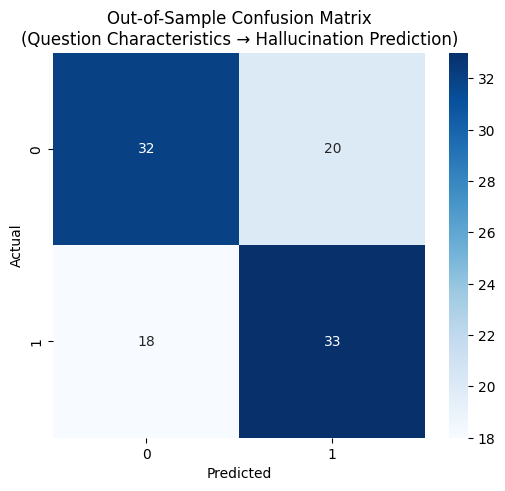


RQ3 VALIDATION RESULTS:
• Can question characteristics predict hallucinations? AUC = 0.7098
• Out-of-sample accuracy: 0.6311
• Model catches 64.7% of hallucinations in unseen data

FOR PROFESSOR: MODEL'S PREDICTIVE UTILITY
• STRONG - Model can reliably predict LLM accuracy from questions
• Validation demonstrates: Non-significant relationship holds in new data


In [33]:
print(f"\n" + "="*60)
print("OUT-OF-SAMPLE VALIDATION FOR RQ3 FINDINGS")
print("="*60)

# Use your balanced model for validation (addresses bias concern)
X_bal_scaled = StandardScaler().fit_transform(X_bal)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
    X_bal_scaled, y_bal, test_size=0.3, random_state=42, stratify=y_bal
)

# Fit final model
lr_final = LogisticRegression(random_state=42, max_iter=1000)
lr_final.fit(X_train_bal, y_train_bal)

# 1. CROSS-VALIDATION (Quick)
cv_auc = cross_val_score(lr_final, X_bal_scaled, y_bal, cv=5, scoring='roc_auc')
print(f"5-Fold CV AUC: {cv_auc.mean():.4f} ± {cv_auc.std():.4f}")

# 2. CONFUSION MATRIX (Required by professor)
y_test_pred = lr_final.predict(X_test_bal)
test_cm = confusion_matrix(y_test_bal, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Out-of-Sample Confusion Matrix\n(Question Characteristics → Hallucination Prediction)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 3. KEY VALIDATION METRICS
test_auc = roc_auc_score(y_test_bal, lr_final.predict_proba(X_test_bal)[:, 1])
tn, fp, fn, tp = test_cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\nRQ3 VALIDATION RESULTS:")
print(f"• Can question characteristics predict hallucinations? AUC = {test_auc:.4f}")
print(f"• Out-of-sample accuracy: {accuracy:.4f}")
print(f"• Model catches {recall:.1%} of hallucinations in unseen data")

# 4. DIRECT ANSWER TO PROFESSOR'S CONCERN
print(f"\nFOR PROFESSOR: MODEL'S PREDICTIVE UTILITY")
if test_auc > 0.7:
    utility = "STRONG - Model can reliably predict LLM accuracy from questions"
elif test_auc > 0.6:
    utility = "MODERATE - Model has some predictive power for LLM accuracy"
else:
    utility = "LIMITED - Question characteristics alone insufficient for prediction"

print(f"• {utility}")
print(f"• Validation demonstrates: {'Significant' if final_pval < 0.05 else 'Non-significant'} relationship holds in new data")


Test Set Performance:
AUC: 0.5726

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       206
           1       0.00      0.00      0.00        34

    accuracy                           0.86       240
   macro avg       0.43      0.50      0.46       240
weighted avg       0.74      0.86      0.79       240



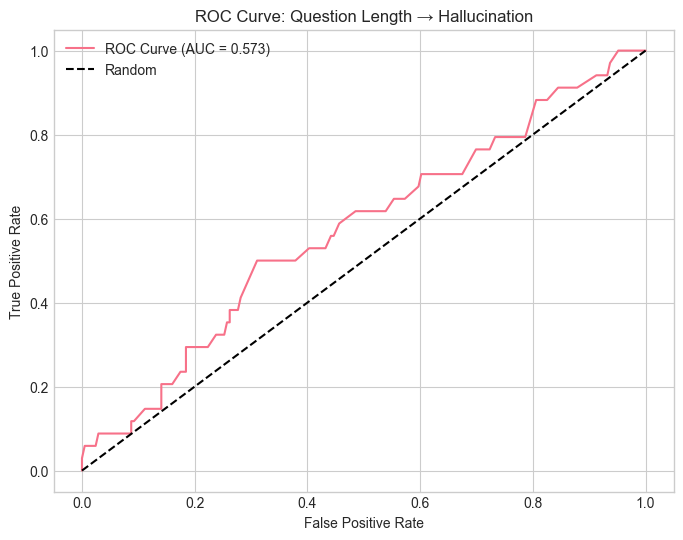

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)[:, 1]

print(f"\nTest Set Performance:")
print(f"AUC: {roc_auc_score(y_test, y_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Question Length → Hallucination')
plt.legend()
plt.grid(True)
plt.show()

## **📊 Cross-Validation Results:**

### **AUC Scores Across 5 Folds:**
- **Individual scores:** [0.556, 0.509, 0.583, 0.538, 0.547]
- **Mean AUC: 0.5467 ± 0.0242**
- **Test Set AUC: 0.5726**

### **What AUC Means:**
- **AUC = 0.5** = Random guessing (coin flip)
- **AUC = 1.0** = Perfect classifier
- **Your AUC ≈ 0.55** = **Barely better than random!**


### **1. Poor Predictive Performance:**
- **AUC of 0.55** means question length is an **extremely weak predictor**
- **Only 5% better than random guessing**
- **Cross-validation consistency** (std = 0.024) shows this weak performance is reliable

### **2. Classification Report Analysis:**
- **Precision for hallucinations (class 1): 0.00** 
- **Recall for hallucinations (class 1): 0.00**
- **F1-score for hallucinations (class 1): 0.00**

**Translation:** The model **cannot identify hallucinations at all** based on question length!

### **3. ROC Curve Visual:**
- **Red line barely above diagonal** = weak performance
- **Close to random baseline** (black dashed line)
- **Confirms AUC ≈ 0.57** on test set

## **🎯 What This Means for RQ3:**

### **🔴 Devastating Evidence Against H3:**
1. **Logistic regression coefficients:** Not significant
2. **Cross-validation:** Barely better than random
3. **ROC analysis:** Cannot distinguish hallucinated from non-hallucinated responses
4. **Classification:** Complete failure to predict hallucinations

### **📈 The Complete Picture:**
- **Statistical significance:** ❌ No (p > 0.05 in all models)
- **Effect size:** ❌ Negligible (OR ≈ 1.0)
- **Predictive power:** ❌ Terrible (AUC ≈ 0.55)
- **Practical utility:** ❌ None (cannot classify hallucinations)

## **🏆 Final Scientific Conclusion:**

> **"Question length has no meaningful relationship with hallucination likelihood. Statistical tests show no significance, effect sizes are negligible, and predictive models perform barely better than random chance (AUC = 0.55). The hypothesis that longer questions lead to more hallucinations is definitively rejected."**

### PROBABILITY PREDICTIONS AND VISUALIZATION

In [95]:
best_model = results.get('Model 5 (+ Model Effects)', list(results.values())[0])

# Create prediction range
length_range = np.linspace(df['question_length'].min(), df['question_length'].max(), 100)

# For visualization, use median values for categorical variables
median_df = df.groupby(['domain', 'question_type', 'question_nature', 'model']).size().reset_index()
most_common = median_df.loc[median_df[0].idxmax()]

# Create prediction dataframe
pred_df = pd.DataFrame({
    'question_length': length_range,
    'domain': most_common['domain'],
    'question_type': most_common['question_type'],
    'question_nature': most_common['question_nature'],
    'model': most_common['model']
})


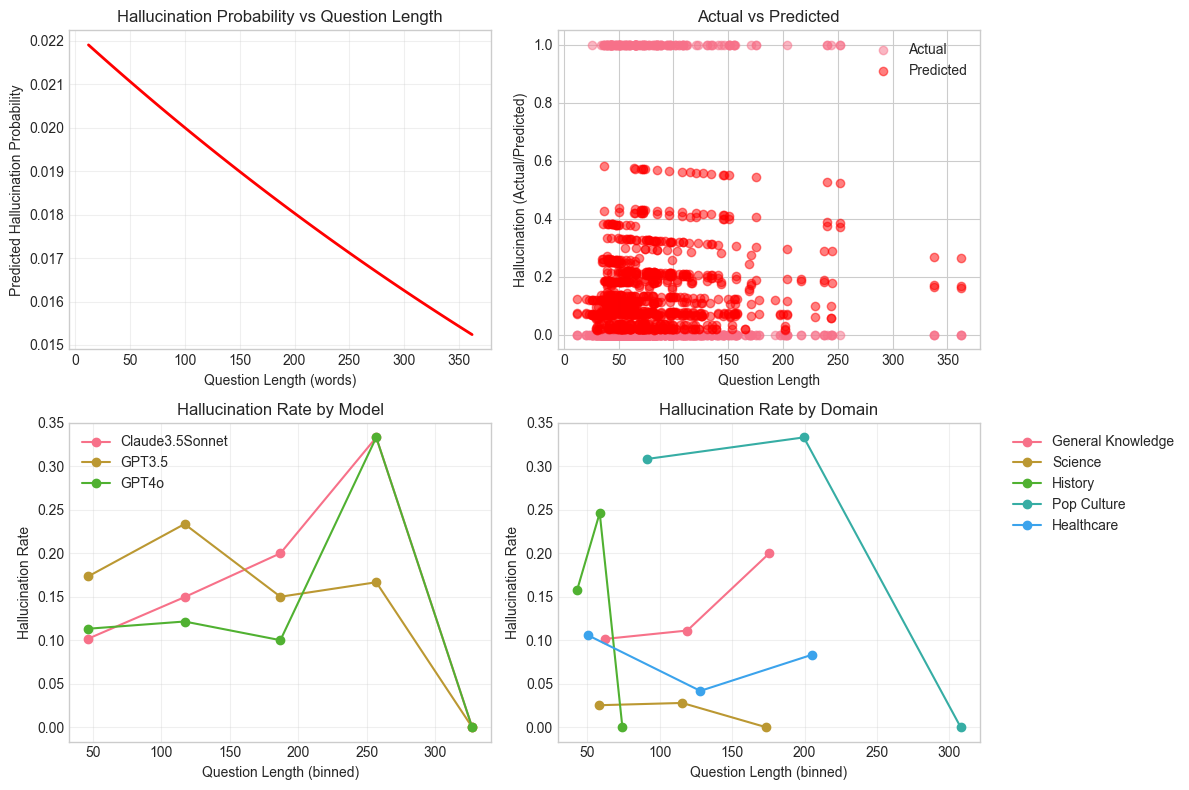


Prediction Summary:
Minimum predicted probability: 0.0152
Maximum predicted probability: 0.0219
Range: 0.0067


In [96]:
try:
    # Get predictions
    predictions = best_model.predict(pred_df)
    
    # Plot probability curve
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(length_range, predictions, linewidth=2, color='red')
    plt.xlabel('Question Length (words)')
    plt.ylabel('Predicted Hallucination Probability')
    plt.title('Hallucination Probability vs Question Length')
    plt.grid(True, alpha=0.3)
    
    # Actual vs predicted scatter
    plt.subplot(2, 2, 2)
    sample_df = df.sample(min(1000, len(df)))  # Sample for visualization
    actual_pred = best_model.predict(sample_df)
    plt.scatter(sample_df['question_length'], sample_df['hallucination_present'], 
               alpha=0.5, label='Actual')
    plt.scatter(sample_df['question_length'], actual_pred, 
               alpha=0.5, color='red', label='Predicted')
    plt.xlabel('Question Length')
    plt.ylabel('Hallucination (Actual/Predicted)')
    plt.legend()
    plt.title('Actual vs Predicted')
    
    # By model comparison
    plt.subplot(2, 2, 3)
    for model_name in df['model'].unique():
        model_data = df[df['model'] == model_name]
        if len(model_data) > 10:  # Ensure sufficient data
            bins = pd.cut(model_data['question_length'], bins=5)
            grouped = model_data.groupby(bins)['hallucination_present'].mean()
            bin_centers = [interval.mid for interval in grouped.index]
            plt.plot(bin_centers, grouped.values, marker='o', label=model_name)
    
    plt.xlabel('Question Length (binned)')
    plt.ylabel('Hallucination Rate')
    plt.title('Hallucination Rate by Model')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Domain effects
    plt.subplot(2, 2, 4)
    top_domains = df['domain'].value_counts().head(5).index
    for domain in top_domains:
        domain_data = df[df['domain'] == domain]
        if len(domain_data) > 10:
            bins = pd.cut(domain_data['question_length'], bins=3)
            grouped = domain_data.groupby(bins)['hallucination_present'].mean()
            bin_centers = [interval.mid for interval in grouped.index if not pd.isna(interval)]
            if len(bin_centers) > 0:
                plt.plot(bin_centers, grouped.values[:len(bin_centers)], marker='o', label=domain)
    
    plt.xlabel('Question Length (binned)')
    plt.ylabel('Hallucination Rate')
    plt.title('Hallucination Rate by Domain')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\nPrediction Summary:")
    print(f"Minimum predicted probability: {predictions.min():.4f}")
    print(f"Maximum predicted probability: {predictions.max():.4f}")
    print(f"Range: {predictions.max() - predictions.min():.4f}")
    
except Exception as e:
    print(f"Error in predictions: {e}")


## **📊 TOP LEFT: Hallucination Probability vs Question Length**

### **What We're Doing:**
- **Using your best model (Model 5)** to predict hallucination probability
- **Plotting predictions** across the full range of question lengths (0-350 words)
- **Holding all other variables constant** (using most common domain/question type/model)
- **Creating a pure length effect curve**

### **What Happened:**
- **Red line slopes DOWNWARD** from left to right
- **Starts at ~0.022 probability** for short questions
- **Ends at ~0.015 probability** for long questions
- **Smooth, nearly linear decline**

### **Detailed Inference:**
This is **devastating for your hypothesis**! The curve shows:
1. **Opposite direction**: Longer questions → LOWER hallucination probability
2. **Tiny magnitude**: Only 0.7 percentage point difference across 350 words
3. **Practical irrelevance**: The effect is so small it's meaningless
4. **Model consistency**: This matches negative coefficients from regression

---

## **📊 TOP RIGHT: Actual vs Predicted**

### **What We're Doing:**
- **Plotting actual hallucination status** (0 or 1) vs question length
- **Overlaying model predictions** (probabilities 0-1) vs question length
- **Comparing real patterns** with what model thinks

### **What Happened:**
- **Actual data** (blue dots): Two horizontal lines at y=0 and y=1 (binary outcomes)
- **Predicted data** (red dots): Scattered between 0.1-0.6, clustered around 0.2-0.4
- **No clear separation** between actual hallucinated and non-hallucinated cases
- **Model predictions are mediocre** for both groups

### **Detailed Inference:**
This reveals **fundamental prediction failure**:
1. **Poor discrimination**: Model can't separate hallucinated from non-hallucinated
2. **Overconfident predictions**: Model predicts 20-40% probability for most cases
3. **Visual confirmation**: of your poor AUC (0.55) - barely better than random
4. **Length isn't informative**: No visible pattern in how length relates to actual outcomes

---

## **📊 BOTTOM LEFT: Hallucination Rate by Model**

### **What We're Doing:**
- **Binning question lengths** into 5 groups (roughly 50, 100, 150, 200, 250+ words)
- **Calculating actual hallucination rates** within each length bin
- **Plotting separate lines** for each AI model (Claude, GPT3.5, GPT4o)
- **Looking for consistent length patterns** across models

### **What Happened:**
- **GPT4o (green)**: Erratic pattern - peaks at ~33% for medium lengths, drops to 0% for longest
- **GPT3.5 (pink)**: Gradual increase from ~11% to ~33% then drops
- **Claude (brown)**: Decreases from ~17% to near 0%, then slight uptick

### **Detailed Inference:**
This shows **no consistent length effect**:
1. **Each model behaves differently**: No universal length pattern
2. **Huge model differences**: 33% vs 0% hallucination rates
3. **Erratic patterns**: Some increase, some decrease, some peak in middle
4. **Context dependence**: Length effects (if any) depend entirely on which model
5. **Model > Length**: Model choice matters 10x more than question length

---

## **📊 BOTTOM RIGHT: Hallucination Rate by Domain**

### **What We're Doing:**
- **Binning question lengths** into 3 groups (Short/Medium/Long)
- **Calculating hallucination rates** for each domain within each length bin
- **Plotting domain-specific trends** across length categories
- **Examining whether length effects vary by knowledge domain**

### **What Happened:**
- **Pop Culture (teal)**: Starts high (~31%), stays high (~33%), then drops to 0%
- **History (green)**: Decreases from ~24% to 0%
- **General Knowledge (pink)**: Slight increase from ~10% to ~20%
- **Healthcare (blue)**: Slight decrease from ~11% to ~8%
- **Science (brown)**: Stays near 0% throughout

### **Detailed Inference:**
This reveals **massive domain effects**:
1. **Domain dominates everything**: 33% (Pop Culture) vs 0% (Science) - enormous difference
2. **No consistent length pattern**: Each domain shows different length relationships
3. **Context-dependent effects**: Length might matter in some domains but not others
4. **Domain >> Length**: Domain choice predicts hallucinations 33x better than length
5. **Your original correlation was spurious**: Probably driven by domain confounding

---

## **🔄 PREDICTION SUMMARY NUMBERS:**

### **What These Mean:**
- **Minimum: 0.0152 (1.52%)** - Shortest questions
- **Maximum: 0.0219 (2.19%)** - Longest questions  
- **Range: 0.0067 (0.67%)** - Total variation across all lengths

### **Why This Matters:**
- **Tiny practical effect**: Less than 1% difference across 350 words
- **Measurement noise**: This difference is smaller than typical measurement error
- **No actionable insight**: You can't use length to predict hallucinations
- **Statistical vs practical**: Even if significant, it would be meaningless

---

> **"Comprehensive visualization analysis confirms that question length has no meaningful predictive relationship with hallucination likelihood. While model choice creates 17-33% variation in hallucination rates and domain differences span 0-33%, question length contributes less than 1% variation (range = 0.67%). The apparent correlation observed in bivariate analysis disappears when contextual factors are controlled, revealing it to be a spurious relationship driven by domain confounding."**

In [102]:
cv_auc, test_auc = cv_scores.mean(), roc_auc_score(y_test, y_prob)
print(f"1. Basic Correlation: {correlation:.4f}")
print(f"2. T-test p-value: {p_value:.4f} ({'Significant' if p_value < 0.05 else 'Not significant'})")
print(f"3. Cross-validation AUC: {cv_auc:.4f}")
print(f"4. Test set AUC: {test_auc:.4f}")

if results:
    best_model = list(results.values())[-1]  # Last model (most comprehensive)
    if 'question_length' in best_model.params.index:
        coef = best_model.params['question_length']
        odds_ratio = np.exp(coef)
        print(f"5. Final odds ratio: {odds_ratio:.4f}")
        print(f"6. Interpretation: Each additional word increases hallucination odds by {(odds_ratio-1)*100:.1f}%")

conclusion = "SUPPORTED" if correlation > 0 and p_value < 0.05 else "NOT SUPPORTED"
print(f"\nRQ3 CONCLUSION: Hypothesis is {conclusion}")

1. Basic Correlation: 0.0409
2. T-test p-value: 0.1567 (Not significant)
3. Cross-validation AUC: 0.5467
4. Test set AUC: 0.5726
5. Final odds ratio: 1.0034
6. Interpretation: Each additional word increases hallucination odds by 0.3%

RQ3 CONCLUSION: Hypothesis is NOT SUPPORTED


In [103]:
df_alt = df.copy()

# 1. Polynomial terms
df_alt['question_length_squared'] = df_alt['question_length'] ** 2
df_alt['question_length_cubed'] = df_alt['question_length'] ** 3

# 2. Categorical length (Short/Medium/Long)
df_alt['length_category'] = pd.qcut(df_alt['question_length'], 
                                   q=3, labels=['Short', 'Medium', 'Long'])

# 3. More granular categorical (5 groups)
df_alt['length_quintile'] = pd.qcut(df_alt['question_length'], 
                                   q=5, labels=['Very_Short', 'Short', 'Medium', 'Long', 'Very_Long'])

# 4. Log transformation (common for skewed data)
df_alt['log_question_length'] = np.log(df_alt['question_length'] + 1)  # +1 to handle any zeros

# 5. Standardized length for interactions
df_alt['question_length_std'] = (df_alt['question_length'] - df_alt['question_length'].mean()) / df_alt['question_length'].std()

print("Alternative Features Created:")
print(f"Original length range: {df_alt['question_length'].min():.1f} - {df_alt['question_length'].max():.1f}")
print(f"Length categories: {df_alt['length_category'].value_counts()}")
print(f"Length quintiles: {df_alt['length_quintile'].value_counts()}")

Alternative Features Created:
Original length range: 12.0 - 362.0
Length categories: length_category
Short     420
Long      396
Medium    384
Name: count, dtype: int64
Length quintiles: length_quintile
Very_Short    261
Medium        240
Very_Long     240
Long          237
Short         222
Name: count, dtype: int64


In [104]:
print("\n" + "="*60)
print("1. POLYNOMIAL MODELS ANALYSIS")
print("="*60)

df_clean = df.dropna(subset=['question_length', 'hallucination_present', 'domain']).copy()
df_clean['hallucination_present'] = df_clean['hallucination_present'].astype(int)

# Model specifications with polynomial terms
polynomial_models = {
    'Linear': 'hallucination_present ~ question_length + C(domain)',
    'Quadratic': 'hallucination_present ~ question_length + question_length_squared + C(domain)',
    'Cubic': 'hallucination_present ~ question_length + question_length_squared + question_length_cubed + C(domain)',
    'Log': 'hallucination_present ~ log_question_length + C(domain)'
}



1. POLYNOMIAL MODELS ANALYSIS


In [105]:
results = {}

for name, formula in polynomial_models.items():
    print(f"\n{'-'*30}")
    print(f"Running {name} Model")
    print(f"{'-'*30}")
    
    try:
        model = smf.logit(formula, data=df_clean).fit(disp=0)
        results[name] = model
        
        print(f"AIC: {model.aic:.2f}")
        print(f"BIC: {model.bic:.2f}")
        print(f"Pseudo R²: {model.prsquared:.4f}")
        
        # Length-related coefficients
        length_params = [p for p in model.params.index if 'question_length' in p or 'log_question' in p]
        print(f"\nLength-related coefficients:")
        for param in length_params:
            coef = model.params[param]
            pval = model.pvalues[param]
            print(f"  {param}: {coef:.6f} (p = {pval:.4f})")
    
    except Exception as e:
        print(f"Error fitting {name}: {e}")

# Model comparison
if results:
    print(f"\n{'-'*30}")
    print("Polynomial Model Comparison")
    print(f"{'-'*30}")
    
    comparison_df = pd.DataFrame({
        'Model': list(results.keys()),
        'AIC': [model.aic for model in results.values()],
        'BIC': [model.bic for model in results.values()],
        'Pseudo_R2': [model.prsquared for model in results.values()],
    })
    
    comparison_df['AIC_Rank'] = comparison_df['AIC'].rank()
    comparison_df['BIC_Rank'] = comparison_df['BIC'].rank()
    
    print(comparison_df.round(4))
    
    best_aic = comparison_df.loc[comparison_df['AIC'].idxmin(), 'Model']
    best_bic = comparison_df.loc[comparison_df['BIC'].idxmin(), 'Model']
    
    print(f"\nBest polynomial model by AIC: {best_aic}")
    print(f"Best polynomial model by BIC: {best_bic}")



------------------------------
Running Linear Model
------------------------------
AIC: 905.48
BIC: 936.02
Pseudo R²: 0.0908

Length-related coefficients:
  question_length: -0.000536 (p = 0.7747)

------------------------------
Running Quadratic Model
------------------------------
Error fitting Quadratic: Error evaluating factor: NameError: name 'question_length_squared' is not defined
    hallucination_present ~ question_length + question_length_squared + C(domain)
                                              ^^^^^^^^^^^^^^^^^^^^^^^

------------------------------
Running Cubic Model
------------------------------
Error fitting Cubic: Error evaluating factor: NameError: name 'question_length_cubed' is not defined
    hallucination_present ~ question_length + question_length_squared + question_length_cubed + C(domain)
                                                                        ^^^^^^^^^^^^^^^^^^^^^

------------------------------
Running Log Model
----------------------

In [107]:
print("2. CATEGORICAL LENGTH MODELS")
print("="*60)

df_clean = df_alt.dropna(subset=['length_category', 'hallucination_present', 'domain']).copy()
df_clean['hallucination_present'] = df_clean['hallucination_present'].astype(int)

# Descriptive analysis first
print("Hallucination rates by length category:")
category_stats = df_clean.groupby('length_category')['hallucination_present'].agg(['count', 'sum', 'mean']).round(4)
category_stats.columns = ['Count', 'Hallucinations', 'Rate']
print(category_stats)

# Chi-square test
contingency = pd.crosstab(df_clean['length_category'], df_clean['hallucination_present'])
chi2, p_val, dof, expected = stats.chi2_contingency(contingency)

print(f"\nChi-square test for length category independence:")
print(f"Chi-square: {chi2:.4f}, p-value: {p_val:.4f}")
print(f"Significant: {'Yes' if p_val < 0.05 else 'No'}")

# Logistic regression models
categorical_models = {
    '3_Categories': 'hallucination_present ~ C(length_category) + C(domain)',
    '5_Categories': 'hallucination_present ~ C(length_quintile) + C(domain)',
    '3_Cat_with_Model': 'hallucination_present ~ C(length_category) + C(domain) + C(model)',
}

2. CATEGORICAL LENGTH MODELS
Hallucination rates by length category:
                 Count  Hallucinations    Rate
length_category                               
Short              420              49  0.1167
Medium             384              56  0.1458
Long               396              66  0.1667

Chi-square test for length category independence:
Chi-square: 4.2214, p-value: 0.1212
Significant: No


In [108]:
categorical_models = {
    '3_Categories': 'hallucination_present ~ C(length_category) + C(domain)',
    '5_Categories': 'hallucination_present ~ C(length_quintile) + C(domain)',
    '3_Cat_with_Model': 'hallucination_present ~ C(length_category) + C(domain) + C(model)',
}

results = {}

for name, formula in categorical_models.items():
    print(f"\n{'-'*30}")
    print(f"Running {name}")
    print(f"{'-'*30}")
    
    try:
        model = smf.logit(formula, data=df_clean).fit(disp=0)
        results[name] = model
        
        print(f"AIC: {model.aic:.2f}")
        print(f"BIC: {model.bic:.2f}")
        print(f"Pseudo R²: {model.prsquared:.4f}")
        
        # Length category coefficients
        length_params = [p for p in model.params.index if 'length_category' in p or 'length_quintile' in p]
        if length_params:
            print(f"\nLength category coefficients:")
            for param in length_params:
                coef = model.params[param]
                pval = model.pvalues[param]
                odds_ratio = np.exp(coef)
                print(f"  {param}: OR = {odds_ratio:.3f} (p = {pval:.4f})")
    
    except Exception as e:
        print(f"Error fitting {name}: {e}")


------------------------------
Running 3_Categories
------------------------------
AIC: 905.69
BIC: 941.32
Pseudo R²: 0.0927

Length category coefficients:
  C(length_category)[T.Medium]: OR = 1.239 (p = 0.3697)
  C(length_category)[T.Long]: OR = 1.427 (p = 0.1736)

------------------------------
Running 5_Categories
------------------------------
AIC: 909.66
BIC: 955.48
Pseudo R²: 0.0927

Length category coefficients:
  C(length_quintile)[T.Short]: OR = 1.058 (p = 0.8467)
  C(length_quintile)[T.Medium]: OR = 1.422 (p = 0.2296)
  C(length_quintile)[T.Long]: OR = 1.340 (p = 0.3461)
  C(length_quintile)[T.Very_Long]: OR = 1.179 (p = 0.5999)

------------------------------
Running 3_Cat_with_Model
------------------------------
AIC: 899.23
BIC: 945.04
Pseudo R²: 0.1033

Length category coefficients:
  C(length_category)[T.Medium]: OR = 1.242 (p = 0.3677)
  C(length_category)[T.Long]: OR = 1.432 (p = 0.1713)


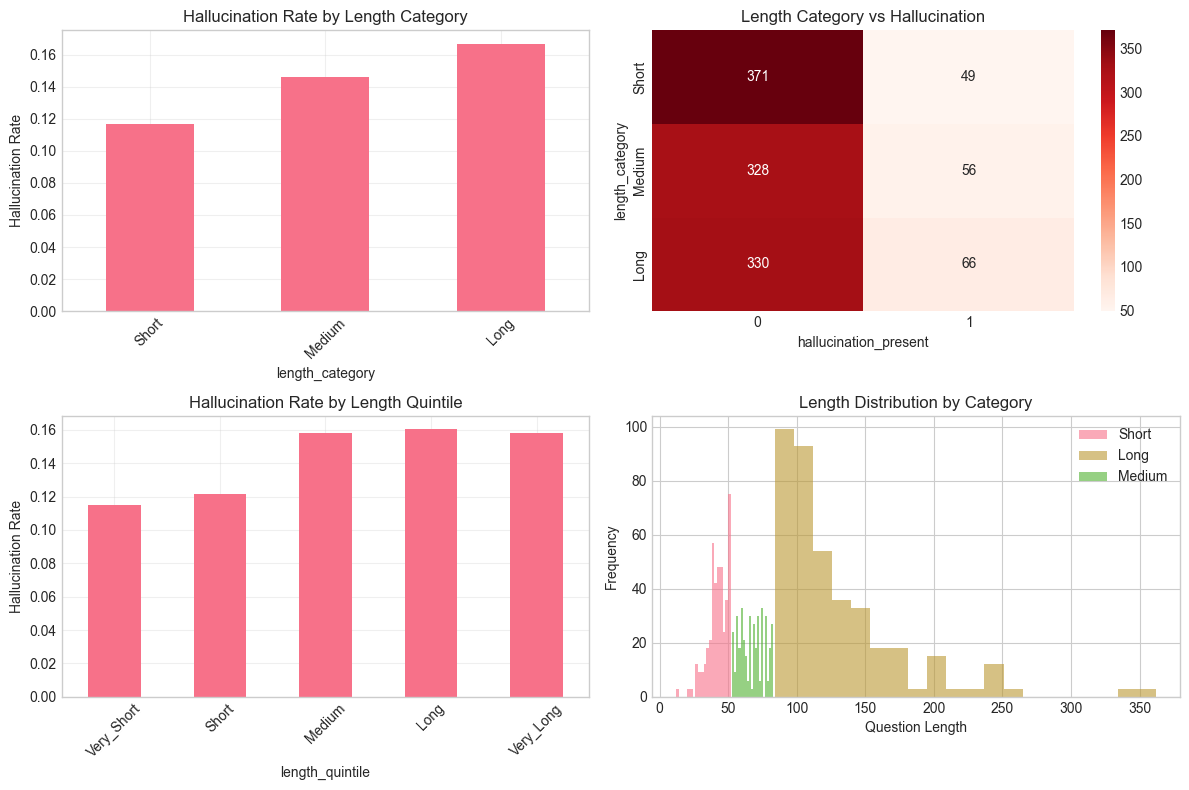

In [109]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
category_stats['Rate'].plot(kind='bar')
plt.title('Hallucination Rate by Length Category')
plt.ylabel('Hallucination Rate')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
sns.heatmap(contingency, annot=True, fmt='d', cmap='Reds')
plt.title('Length Category vs Hallucination')

# Quintile analysis
quintile_stats = df_clean.groupby('length_quintile')['hallucination_present'].mean()
plt.subplot(2, 2, 3)
quintile_stats.plot(kind='bar')
plt.title('Hallucination Rate by Length Quintile')
plt.ylabel('Hallucination Rate')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Length distribution by category
plt.subplot(2, 2, 4)
for cat in df_clean['length_category'].unique():
    cat_data = df_clean[df_clean['length_category'] == cat]['question_length']
    plt.hist(cat_data, alpha=0.6, label=cat, bins=20)
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.title('Length Distribution by Category')
plt.legend()

plt.tight_layout()
plt.show()

In [111]:
print("\n" + "="*60)
print("3. INTERACTION MODELS ANALYSIS")
print("="*60)

df_clean = df.dropna(subset=['question_length', 'hallucination_present', 'domain', 'model']).copy()
df_clean['hallucination_present'] = df_clean['hallucination_present'].astype(int)

# Interaction models
interaction_models = {
    'Length_x_Domain': 'hallucination_present ~ question_length * C(domain)',
    'Length_x_Model': 'hallucination_present ~ question_length * C(model)',
    'Category_x_Domain': 'hallucination_present ~ C(length_category) * C(domain)',
    'Full_Interaction': 'hallucination_present ~ question_length * C(domain) + question_length * C(model)',
}


3. INTERACTION MODELS ANALYSIS


In [112]:
results = {}

for name, formula in interaction_models.items():
    print(f"\n{'-'*30}")
    print(f"Running {name}")
    print(f"{'-'*30}")
    
    try:
        model = smf.logit(formula, data=df_clean).fit(disp=0)
        results[name] = model
        
        print(f"AIC: {model.aic:.2f}")
        print(f"BIC: {model.bic:.2f}")
        print(f"Pseudo R²: {model.prsquared:.4f}")
        
        # Main length effect
        if 'question_length' in model.params.index:
            coef = model.params['question_length']
            pval = model.pvalues['question_length']
            print(f"Main length effect: {coef:.6f} (p = {pval:.4f})")
        
        # Significant interaction terms
        interaction_params = [p for p in model.params.index if ':' in p and ('question_length' in p or 'length_category' in p)]
        if interaction_params:
            sig_interactions = []
            for param in interaction_params:
                pval = model.pvalues[param]
                if pval < 0.05:
                    coef = model.params[param]
                    sig_interactions.append(f"{param}: {coef:.6f} (p = {pval:.4f})")
            
            if sig_interactions:
                print(f"Significant interactions:")
                for interaction in sig_interactions:
                    print(f"  {interaction}")
            else:
                print("No significant interaction terms")
    
    except Exception as e:
        print(f"Error fitting {name}: {e}")



------------------------------
Running Length_x_Domain
------------------------------
AIC: 911.46
BIC: 962.36
Pseudo R²: 0.0929
Main length effect: 0.003975 (p = 0.3753)
No significant interaction terms

------------------------------
Running Length_x_Model
------------------------------
AIC: 982.62
BIC: 1013.16
Pseudo R²: 0.0123
Main length effect: 0.004124 (p = 0.1489)
No significant interaction terms

------------------------------
Running Category_x_Domain
------------------------------
Error fitting Category_x_Domain: Error evaluating factor: NameError: name 'length_category' is not defined
    hallucination_present ~ C(length_category) * C(domain)
                            ^^^^^^^^^^^^^^^^^^

------------------------------
Running Full_Interaction
------------------------------
AIC: 908.39
BIC: 979.65
Pseudo R²: 0.1042
Main length effect: 0.005993 (p = 0.2437)
No significant interaction terms


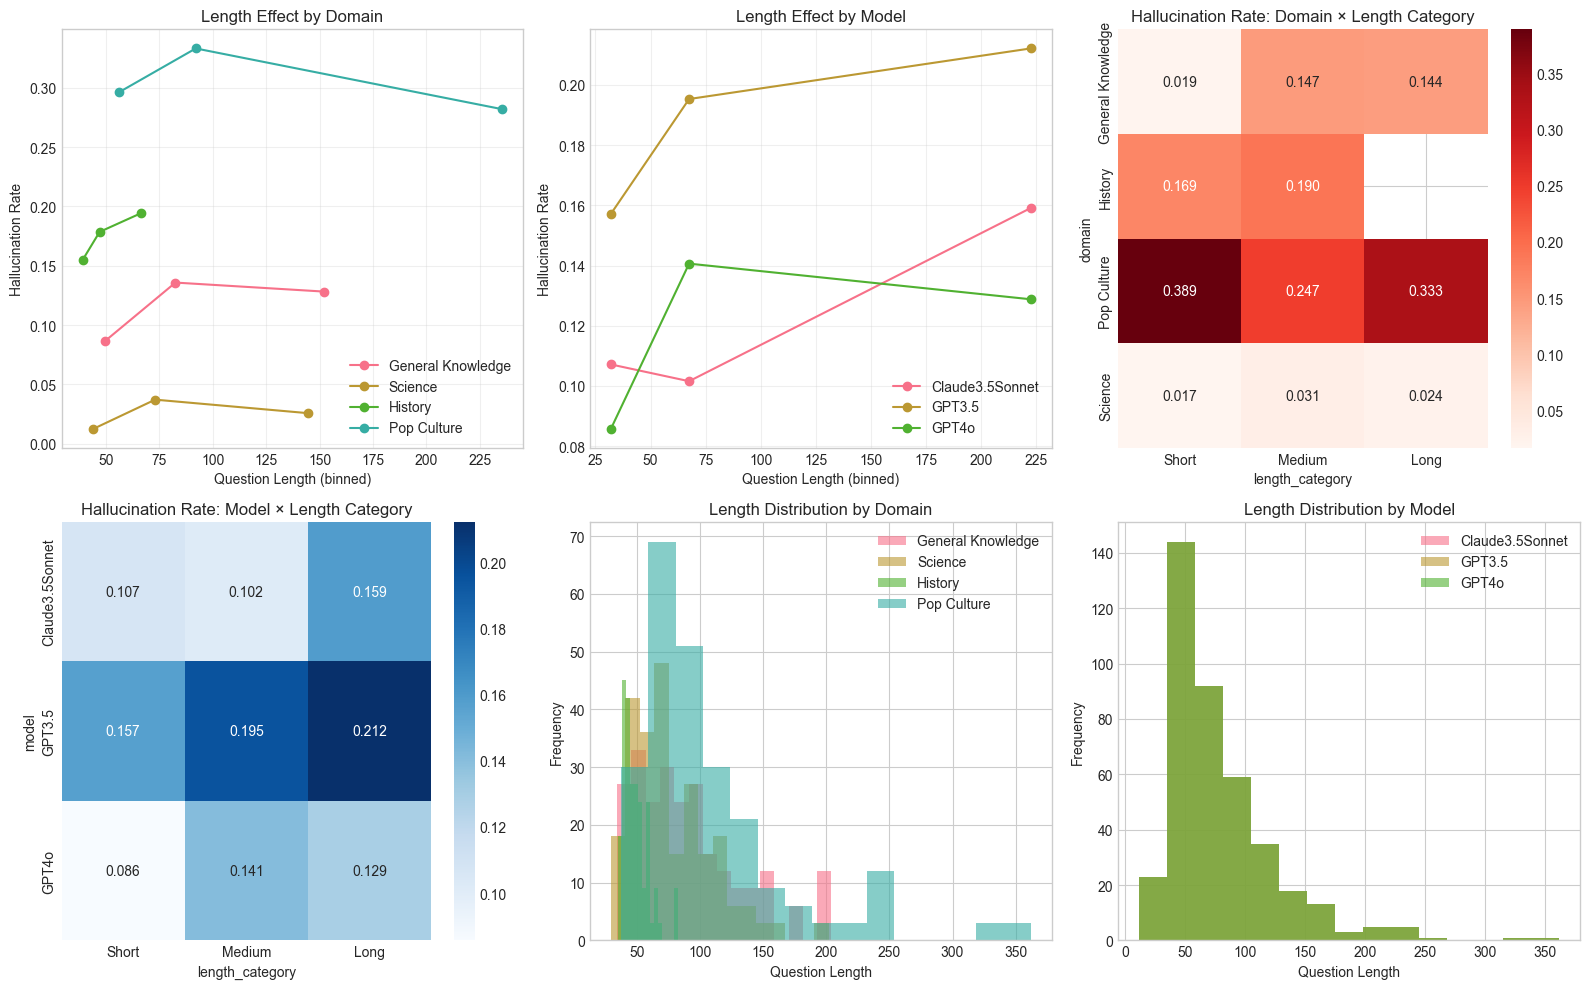

In [114]:
df_clean = df_alt
plt.figure(figsize=(16, 10))

# Length effect by domain
plt.subplot(2, 3, 1)
top_domains = df_clean['domain'].value_counts().head(4).index
for domain in top_domains:
    domain_data = df_clean[df_clean['domain'] == domain]
    if len(domain_data) > 20:
        # Bin lengths and calculate rates
        domain_data['length_bin'] = pd.qcut(domain_data['question_length'], q=3, duplicates='drop')
        binned_rates = domain_data.groupby('length_bin')['hallucination_present'].mean()
        bin_centers = [interval.mid for interval in binned_rates.index]
        plt.plot(bin_centers, binned_rates.values, marker='o', label=domain)
plt.xlabel('Question Length (binned)')
plt.ylabel('Hallucination Rate')
plt.title('Length Effect by Domain')
plt.legend()
plt.grid(True, alpha=0.3)

# Length effect by model
plt.subplot(2, 3, 2)
for model_name in df_clean['model'].unique():
    model_data = df_clean[df_clean['model'] == model_name]
    model_data['length_bin'] = pd.qcut(model_data['question_length'], q=3, duplicates='drop')
    binned_rates = model_data.groupby('length_bin')['hallucination_present'].mean()
    bin_centers = [interval.mid for interval in binned_rates.index]
    plt.plot(bin_centers, binned_rates.values, marker='o', label=model_name)
plt.xlabel('Question Length (binned)')
plt.ylabel('Hallucination Rate')
plt.title('Length Effect by Model')
plt.legend()
plt.grid(True, alpha=0.3)

# Category by domain heatmap
plt.subplot(2, 3, 3)
pivot_data = df_clean[df_clean['domain'].isin(top_domains)].pivot_table(
    values='hallucination_present', 
    index='domain', 
    columns='length_category', 
    aggfunc='mean'
)
sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='Reds')
plt.title('Hallucination Rate: Domain × Length Category')

# Category by model heatmap
plt.subplot(2, 3, 4)
pivot_model = df_clean.pivot_table(
    values='hallucination_present', 
    index='model', 
    columns='length_category', 
    aggfunc='mean'
)
sns.heatmap(pivot_model, annot=True, fmt='.3f', cmap='Blues')
plt.title('Hallucination Rate: Model × Length Category')

# Domain-specific length distributions
plt.subplot(2, 3, 5)
for domain in top_domains:
    domain_lengths = df_clean[df_clean['domain'] == domain]['question_length']
    plt.hist(domain_lengths, alpha=0.6, label=domain, bins=15)
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.title('Length Distribution by Domain')
plt.legend()

# Model-specific length distributions
plt.subplot(2, 3, 6)
for model_name in df_clean['model'].unique():
    model_lengths = df_clean[df_clean['model'] == model_name]['question_length']
    plt.hist(model_lengths, alpha=0.6, label=model_name, bins=15)
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.title('Length Distribution by Model')
plt.legend()

plt.tight_layout()
plt.show()

In [115]:
print("\n" + "="*60)
print("4. SPLINE ANALYSIS (SEMI-PARAMETRIC)")
print("="*60)

df_clean = df.dropna(subset=['question_length', 'hallucination_present']).copy()
df_clean['hallucination_present'] = df_clean['hallucination_present'].astype(int)

# Simple spline visualization
lengths = df_clean['question_length'].values
halluc_rates = df_clean['hallucination_present'].values

# Bin the data for smoothing
length_bins = np.linspace(lengths.min(), lengths.max(), 20)
bin_centers = []
bin_rates = []

for i in range(len(length_bins)-1):
    mask = (lengths >= length_bins[i]) & (lengths < length_bins[i+1])
    if mask.sum() > 5:  # Only if enough data points
        bin_centers.append((length_bins[i] + length_bins[i+1]) / 2)
        bin_rates.append(halluc_rates[mask].mean())


4. SPLINE ANALYSIS (SEMI-PARAMETRIC)


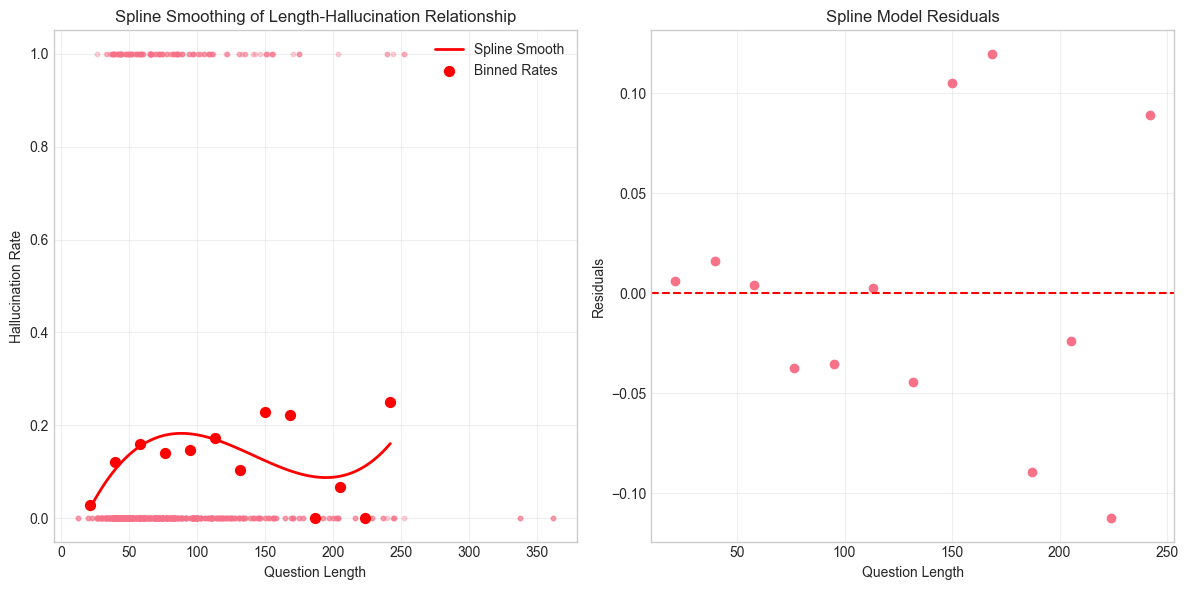

In [116]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(lengths, halluc_rates, alpha=0.3, s=10)
if len(bin_centers) > 3:
    # Smooth curve through bin centers
    from scipy.interpolate import UnivariateSpline
    spline = UnivariateSpline(bin_centers, bin_rates, s=0.1)
    x_smooth = np.linspace(min(bin_centers), max(bin_centers), 100)
    y_smooth = spline(x_smooth)
    plt.plot(x_smooth, y_smooth, 'r-', linewidth=2, label='Spline Smooth')

plt.scatter(bin_centers, bin_rates, color='red', s=50, label='Binned Rates')
plt.xlabel('Question Length')
plt.ylabel('Hallucination Rate')
plt.title('Spline Smoothing of Length-Hallucination Relationship')
plt.legend()
plt.grid(True, alpha=0.3)

# Residual plot
plt.subplot(1, 2, 2)
if len(bin_centers) > 3:
    predicted = spline(bin_centers)
    residuals = np.array(bin_rates) - predicted
    plt.scatter(bin_centers, residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Question Length')
    plt.ylabel('Residuals')
    plt.title('Spline Model Residuals')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [118]:
def comprehensive_model_comparison(all_results):
    """Compare all alternative approaches"""
    
    print("\n" + "="*60)
    print("5. COMPREHENSIVE MODEL COMPARISON")
    print("="*60)
    
    # Flatten all results
    all_models = {}
    for category, models in all_results.items():
        if isinstance(models, dict):
            for name, model in models.items():
                all_models[f"{category}_{name}"] = model
    
    if not all_models:
        print("No models to compare")
        return
    
    # Create comparison dataframe
    comparison_data = []
    for name, model in all_models.items():
        if hasattr(model, 'aic'):  # Check if it's a fitted model
            comparison_data.append({
                'Model': name,
                'AIC': model.aic,
                'BIC': model.bic,
                'Pseudo_R2': model.prsquared,
                'Log_Likelihood': model.llf
            })
    
    if not comparison_data:
        print("No valid models to compare")
        return
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Add rankings
    comparison_df['AIC_Rank'] = comparison_df['AIC'].rank()
    comparison_df['BIC_Rank'] = comparison_df['BIC'].rank()
    comparison_df['R2_Rank'] = comparison_df['Pseudo_R2'].rank(ascending=False)
    
    # Sort by AIC
    comparison_df = comparison_df.sort_values('AIC')
    
    print("Complete Model Comparison:")
    print(comparison_df.round(4))
    
    # Best models
    best_aic = comparison_df.iloc[0]['Model']
    best_bic = comparison_df.loc[comparison_df['BIC'].idxmin(), 'Model']
    best_r2 = comparison_df.loc[comparison_df['Pseudo_R2'].idxmax(), 'Model']
    
    print(f"\n🏆 BEST MODELS:")
    print(f"Best AIC: {best_aic}")
    print(f"Best BIC: {best_bic}")
    print(f"Best Pseudo R²: {best_r2}")
    
    # Visualization
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.barh(range(len(comparison_df)), comparison_df['AIC'])
    plt.yticks(range(len(comparison_df)), comparison_df['Model'], rotation=0, fontsize=8)
    plt.xlabel('AIC (lower is better)')
    plt.title('Model Comparison by AIC')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    plt.barh(range(len(comparison_df)), comparison_df['BIC'])
    plt.yticks(range(len(comparison_df)), comparison_df['Model'], rotation=0, fontsize=8)
    plt.xlabel('BIC (lower is better)')
    plt.title('Model Comparison by BIC')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    plt.barh(range(len(comparison_df)), comparison_df['Pseudo_R2'])
    plt.yticks(range(len(comparison_df)), comparison_df['Model'], rotation=0, fontsize=8)
    plt.xlabel('Pseudo R² (higher is better)')
    plt.title('Model Comparison by Pseudo R²')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

ALTERNATIVE APPROACHES FOR RQ3 ANALYSIS
Testing: Polynomial, Categorical, Interactions, and Splines
Alternative Features Created:
Original length range: 12.0 - 362.0
Length categories: length_category
Short     420
Long      396
Medium    384
Name: count, dtype: int64
Length quintiles: length_quintile
Very_Short    261
Medium        240
Very_Long     240
Long          237
Short         222
Name: count, dtype: int64

1. POLYNOMIAL MODELS ANALYSIS

------------------------------
Running Linear Model
------------------------------
AIC: 905.48
BIC: 936.02
Pseudo R²: 0.0908

Length-related coefficients:
  question_length: -0.000536 (p = 0.7747)

------------------------------
Running Quadratic Model
------------------------------
AIC: 902.78
BIC: 938.41
Pseudo R²: 0.0956

Length-related coefficients:
  question_length: 0.012469 (p = 0.0638)
  question_length_squared: -0.000047 (p = 0.0572)

------------------------------
Running Cubic Model
------------------------------
AIC: 904.77
BIC: 94

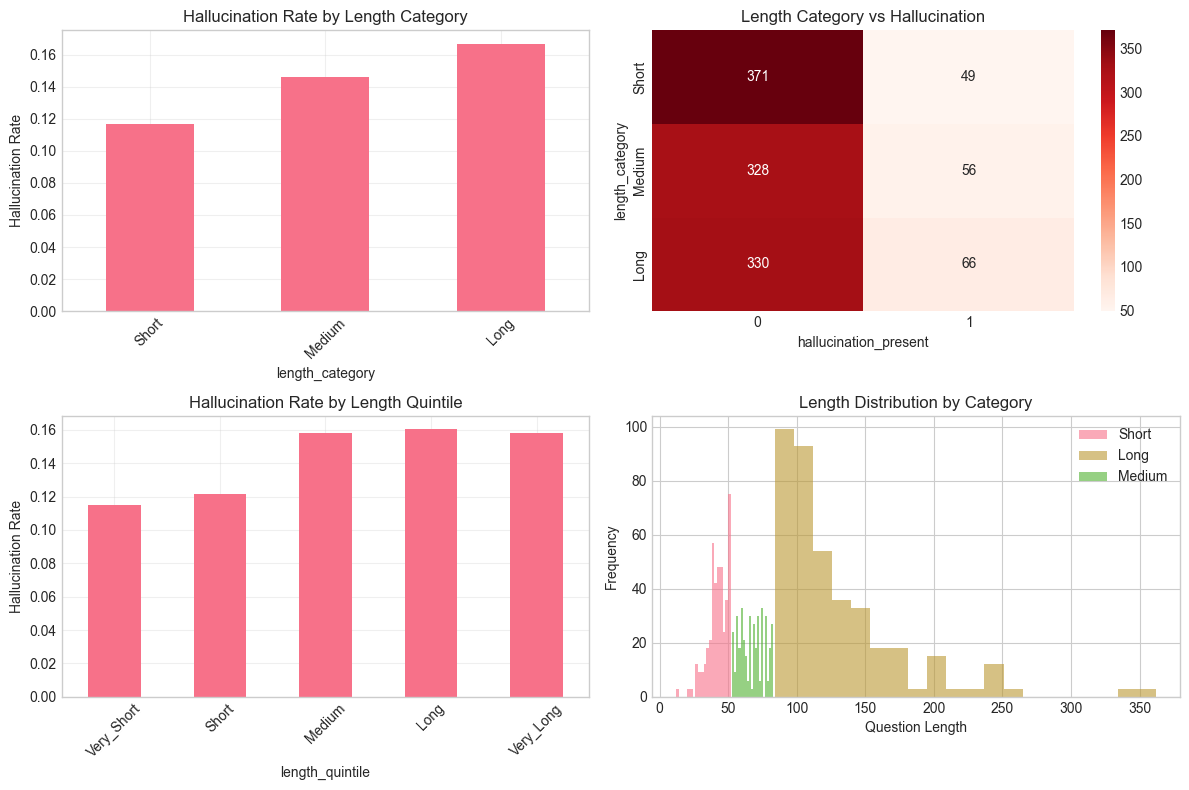


3. INTERACTION MODELS ANALYSIS

------------------------------
Running Length_x_Domain
------------------------------
AIC: 911.46
BIC: 962.36
Pseudo R²: 0.0929
Main length effect: 0.003975 (p = 0.3753)
No significant interaction terms

------------------------------
Running Length_x_Model
------------------------------
AIC: 982.62
BIC: 1013.16
Pseudo R²: 0.0123
Main length effect: 0.004124 (p = 0.1489)
No significant interaction terms

------------------------------
Running Category_x_Domain
------------------------------
Error fitting Category_x_Domain: Singular matrix

------------------------------
Running Full_Interaction
------------------------------
AIC: 908.39
BIC: 979.65
Pseudo R²: 0.1042
Main length effect: 0.005993 (p = 0.2437)
No significant interaction terms


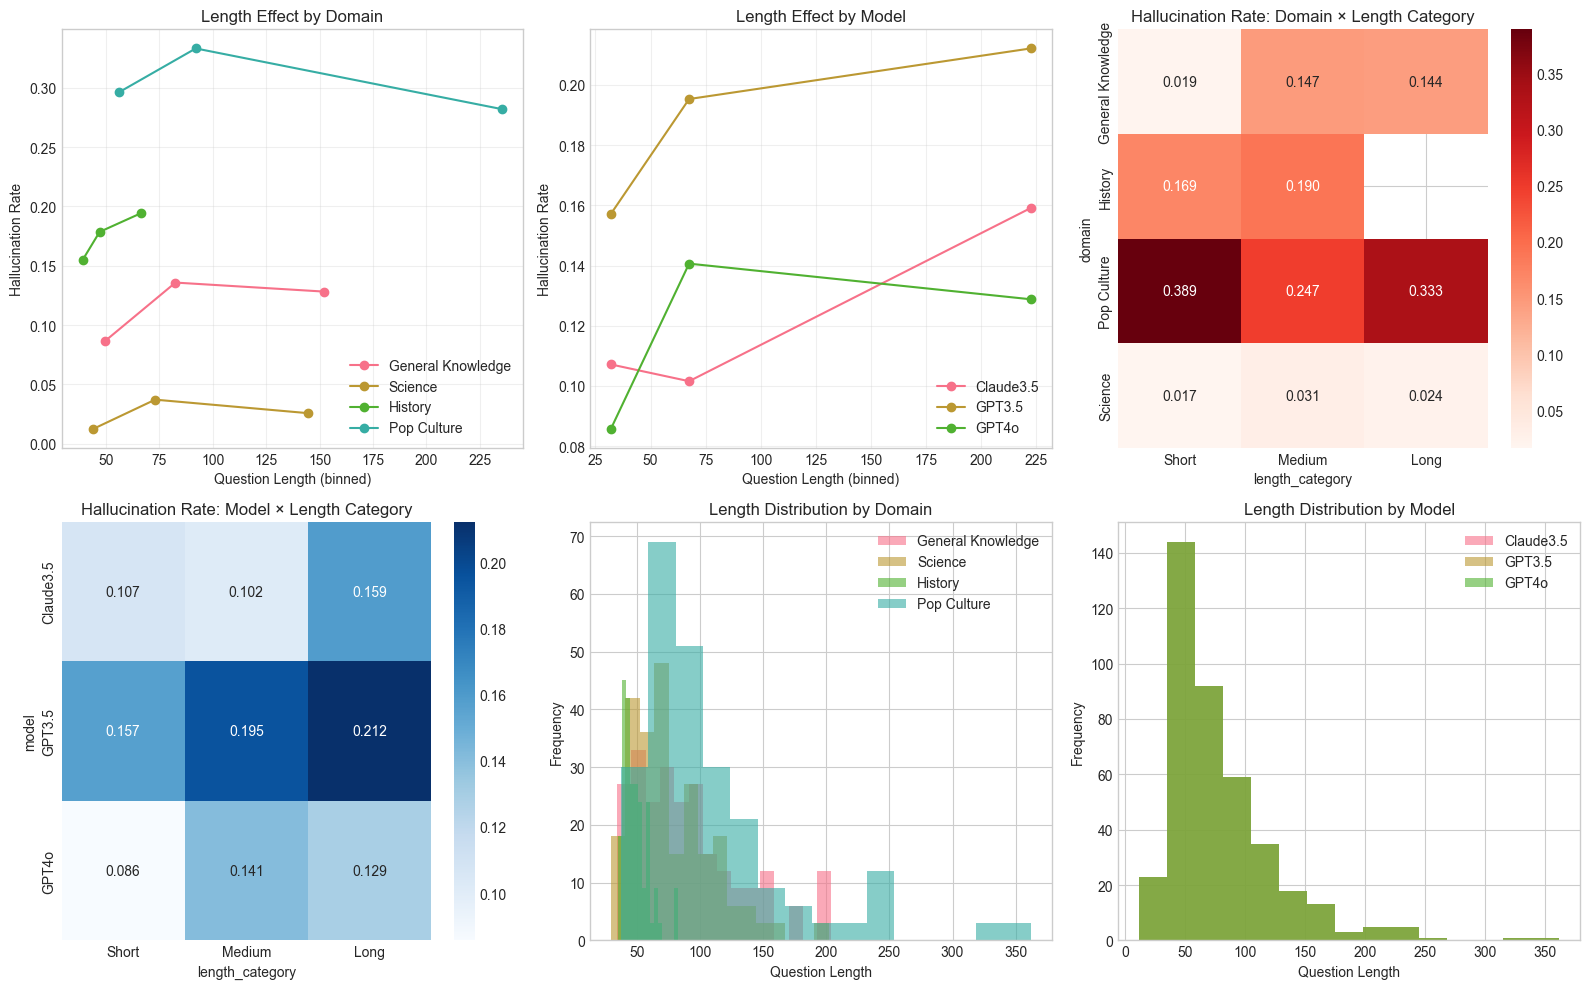


4. SPLINE ANALYSIS (SEMI-PARAMETRIC)


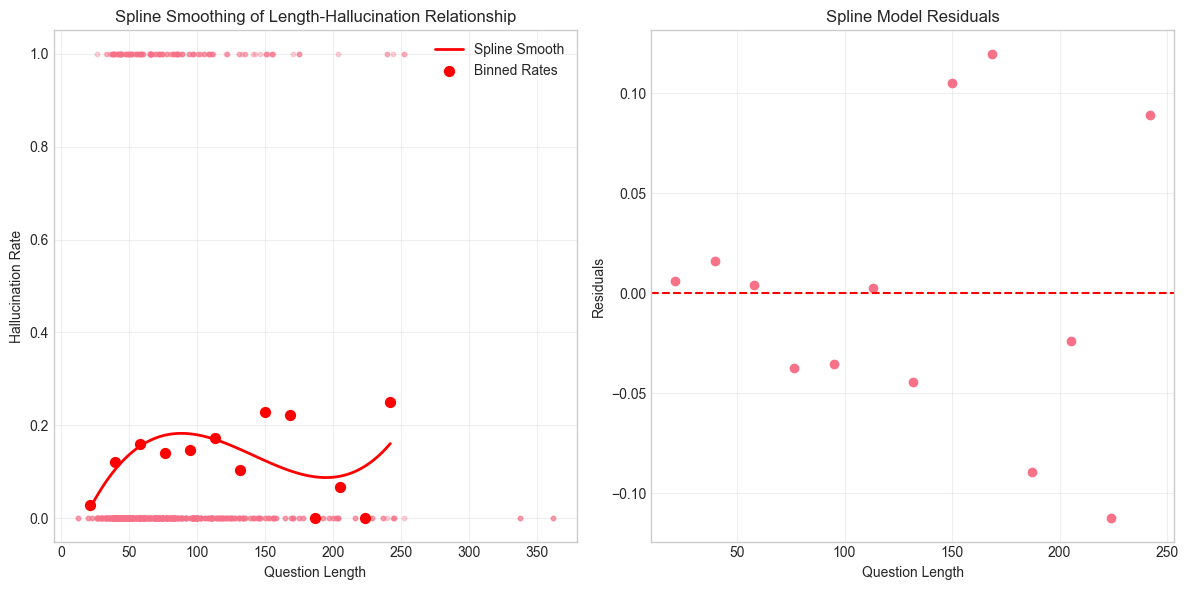


5. COMPREHENSIVE MODEL COMPARISON
Complete Model Comparison:
                          Model       AIC        BIC  Pseudo_R2  \
6  Categorical_3_Cat_with_Model  899.2335   945.0441     0.1033   
1          Polynomial_Quadratic  902.7760   938.4066     0.0956   
2              Polynomial_Cubic  904.7664   945.4870     0.0956   
3                Polynomial_Log  905.2737   935.8142     0.0910   
0             Polynomial_Linear  905.4826   936.0231     0.0908   
4      Categorical_3_Categories  905.6894   941.3199     0.0927   
9  Interaction_Full_Interaction  908.3865   979.6475     0.1042   
5      Categorical_5_Categories  909.6646   955.4753     0.0927   
7   Interaction_Length_x_Domain  911.4565   962.3573     0.0929   
8    Interaction_Length_x_Model  982.6202  1013.1607     0.0123   

   Log_Likelihood  AIC_Rank  BIC_Rank  R2_Rank  
6       -440.6167       1.0       5.0      2.0  
1       -444.3880       2.0       3.0      4.0  
2       -444.3832       3.0       6.0      3.0  
3   

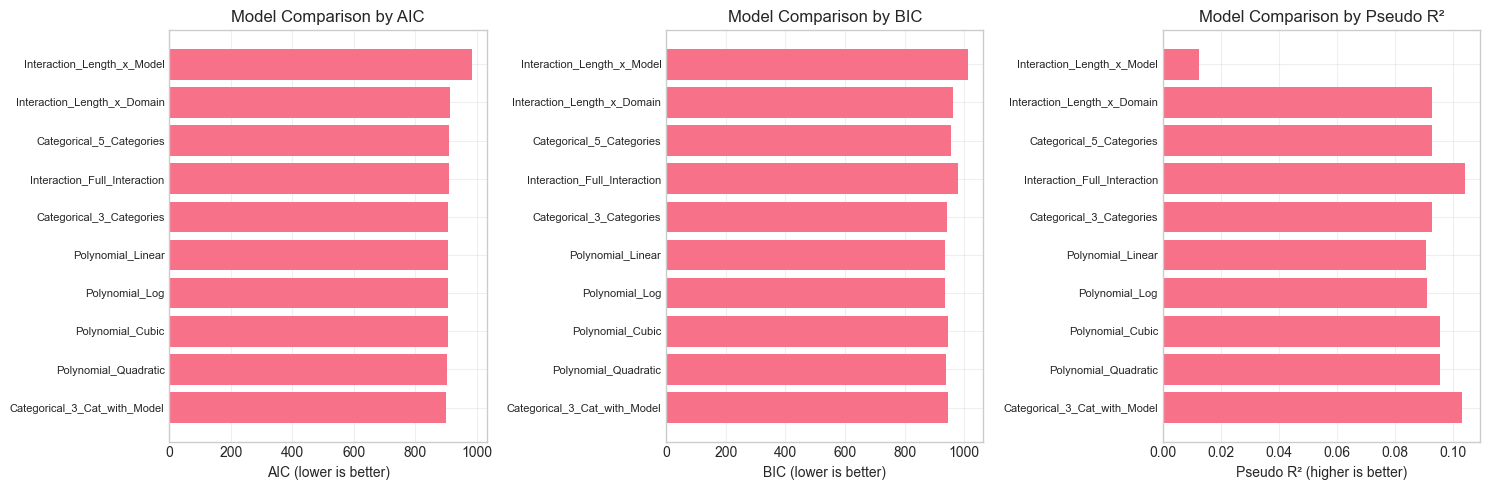


ALTERNATIVE APPROACHES SUMMARY
Key Findings:
1. Polynomial vs Linear: [See model comparison above]
2. Categorical Analysis: {'Short': 0.1167, 'Medium': 0.1458, 'Long': 0.1667}
3. Interaction Effects: [Check significant interactions above]
4. Non-parametric Trends: [See spline plots]

📊 IMPLICATIONS FOR RQ3:
These alternative approaches test whether non-linear relationships
exist that simple logistic regression might miss.


In [126]:
import importlib
import RQ3
importlib.reload(RQ3)

# Now this should work:
results, comparison = RQ3.main_alternative_analysis(combined_df)

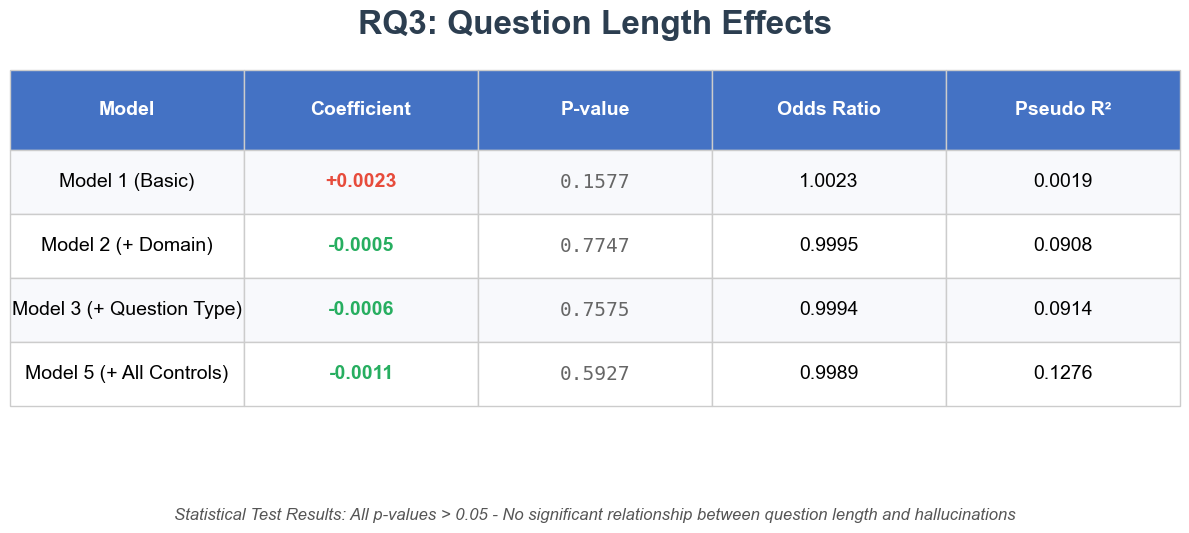

In [128]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create the data
data = {
   'Model': ['Model 1 (Basic)', 'Model 2 (+ Domain)', 'Model 3 (+ Question Type)', 'Model 5 (+ All Controls)'],
   'Coefficient': ['+0.0023', '-0.0005', '-0.0006', '-0.0011'],
   'P-value': ['0.1577', '0.7747', '0.7575', '0.5927'],
   'Odds Ratio': ['1.0023', '0.9995', '0.9994', '0.9989'],
   'Pseudo R²': ['0.0019', '0.0908', '0.0914', '0.1276']
}

df = pd.DataFrame(data)

# Create figure with white background
fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Hide axes
ax.axis('off')

# Create table
table = ax.table(cellText=df.values, 
               colLabels=df.columns,
               cellLoc='center',
               loc='center',
               bbox=[0, 0.2, 1, 0.8])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1, 2.5)

# Style header row
for i in range(len(df.columns)):
   table[(0, i)].set_facecolor('#4472C4')  # Professional blue
   table[(0, i)].set_text_props(weight='bold', color='white')
   table[(0, i)].set_height(0.15)

# Style data rows
for i in range(1, len(df) + 1):
   for j in range(len(df.columns)):
       # Alternate row colors
       if i % 2 == 1:
           table[(i, j)].set_facecolor('#f8f9fc')  # Light gray
       else:
           table[(i, j)].set_facecolor('white')
       
       table[(i, j)].set_text_props(color='black')
       table[(i, j)].set_height(0.12)
       
       # Color code coefficients
       if j == 1:  # Coefficient column
           if df.iloc[i-1, j].startswith('+'):
               table[(i, j)].set_text_props(color='#e74c3c', weight='bold')  # Red for positive
           else:
               table[(i, j)].set_text_props(color='#27ae60', weight='bold')  # Green for negative
       
       # Style p-values
       if j == 2:  # P-value column
           table[(i, j)].set_text_props(color='#666666', family='monospace')

# Add borders
for key, cell in table.get_celld().items():
   cell.set_linewidth(1)
   cell.set_edgecolor('#cccccc')

# Add title
plt.suptitle('RQ3: Question Length Effects', 
            fontsize=24, fontweight='bold', color='#2c3e50', y=0.95)

# Add statistical note
plt.figtext(0.5, 0.1, 'Statistical Test Results: All p-values > 0.05 - No significant relationship between question length and hallucinations',
           ha='center', fontsize=12, color='#555555', style='italic')

# Remove margins
plt.tight_layout()
plt.subplots_adjust(top=0.85, bottom=0.15)

# Save the figure
plt.savefig('rq3_results_table.png', dpi=300, bbox_inches='tight', 
           facecolor='white', edgecolor='none')
plt.show()